# Compare different types of buffer zones
1) constant spacing
2) constant spacing with lower resolution
3) buffer zone with wider spacing than inner region
4) buffer zone with multiple increases in spacing

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

# local python scripts
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth

from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt
import pvxarray
import pyvista as pv
import time

PROJ: proj_create_from_database: Cannot find proj.db


## useful functions

In [2]:
def forward_grav_of_prismlayer(
    prisms: list,
    observation_points: tuple,
    plot: bool = True,
    **kwargs,
):
    grids = []
    t0=time.time()
    for i, p in enumerate(prisms):
        grav = p.prism_layer.gravity(
            coordinates=observation_points,
            field="g_z",
            progressbar=True,
        )
        
        # shift so max value is 0
        grav -= grav.max()

        grav_grid = vd.make_xarray_grid(
            coordinates=observation_points,
            data=grav,
            data_names="grav",
            extra_coords_names="height",
        ).grav

        grids.append(grav_grid)
    t1 = time.time()

    def sum_list(l):
        total = 0
        for x in l:
            total += x
        
        # shift so max value is 0
        total -= total.max()
        
        return total

    if len(grids) > 1:
        total_forward = sum_list(grids)
        grids.append(total_forward)

    if plot is True:
        for i, g in enumerate(grids):
            if i == 0:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[0],
                    coast=True,
                    frame=["nSWe", "xaf20000", "yaf20000"],
                    cbar_yoffset=1,
                )
            elif i == len(grids) - 1:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title="Total forward gravity",
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                    frame=["nSWe", "xaf20000", "yaf20000"],
                    cbar_yoffset=1,
                )
            else:
                fig = maps.plot_grd(
                    g,
                    cmap="viridis",
                    cbar_label="mGal",
                    title=kwargs.get("names", "Forward gravity of prisms")[i],
                    coast=True,
                    fig=fig,
                    origin_shift="xshift",
                    frame=["nSWe", "xaf20000", "yaf20000"],
                    cbar_yoffset=2,
                )
            fig.plot(
                x=(inner_region[0], inner_region[1]),
                y=(inner_region[2], inner_region[3]),
                pen="1p,red",
            )
            
        fig.show()

        data_dict = profile.make_data_dict(
            names=["Total forward gravity"],
            grids=[grids[-1]],
            colors=["black"],
        )

        profile.plot_data(
            "points",
            start=(inner_region[0], inner_region[2]),
            stop=(inner_region[1], inner_region[3]),
            data_dict=data_dict,
        )

    return grids, t1-t0

# Setup parameter

In [3]:
spacing = 2e3

inner_region = [-50e3, 50e3, -50e3, 50e3]

observation_points = vd.grid_coordinates(
    inner_region,
    spacing=spacing,
    extra_coords=1e3,
)

density=2670
prism_top=100
prism_base=-200

# Constant grid spacing

## define regions

In [4]:
buffer_zoom = 100e3

buffer_region = utils.alter_region(inner_region, buffer=buffer_zoom)[1]

print(f"inner region: {inner_region}")
print(f"buffer region: {buffer_region}")

inner region: [-50000.0, 50000.0, -50000.0, 50000.0]
buffer region: [-150000, 150000, -150000, 150000]


## make surface grid

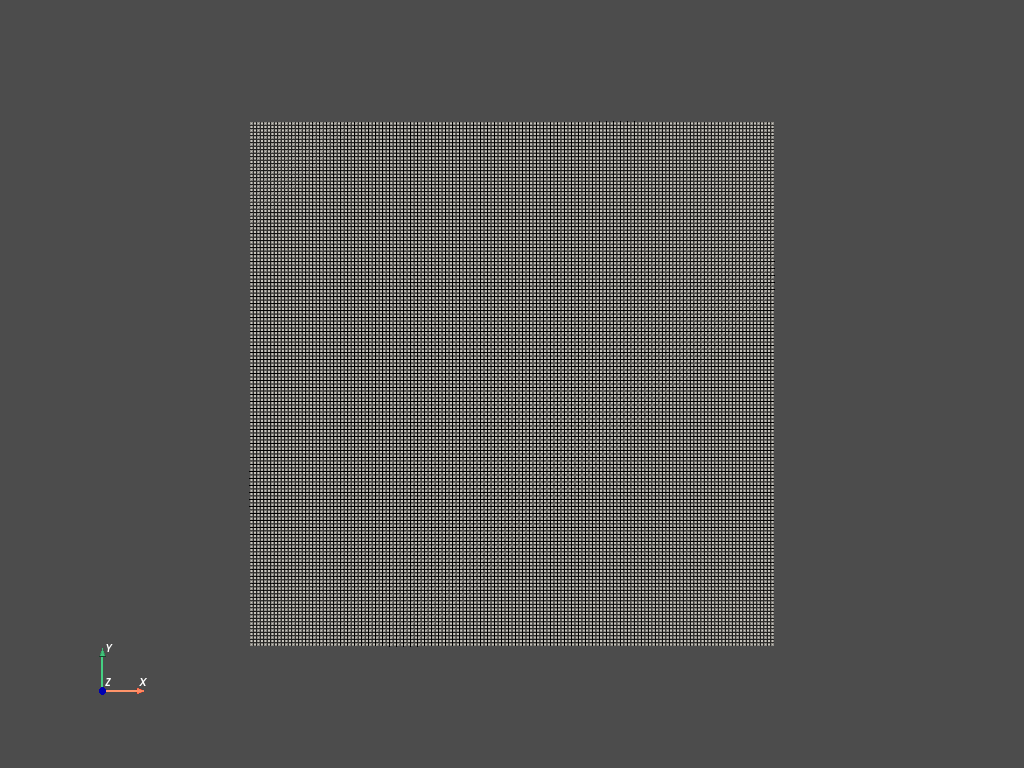

In [5]:
# create grid of coordinates
(easting, northing) = vd.grid_coordinates(
    region=buffer_region,
    spacing=spacing,
)

surface = vd.make_xarray_grid(
    (easting, northing), 
    np.ones_like(easting)*prism_top,
    data_names="z", dims=("y", "x")
).z

surface.pyvista.plot(x="x", y="y", show_edges=True, cpos='xy', 
    jupyter_backend='static', color='white')

## Forward gravity

Number of prisms: 22801


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/2601 [00:00<?, ?it/s]

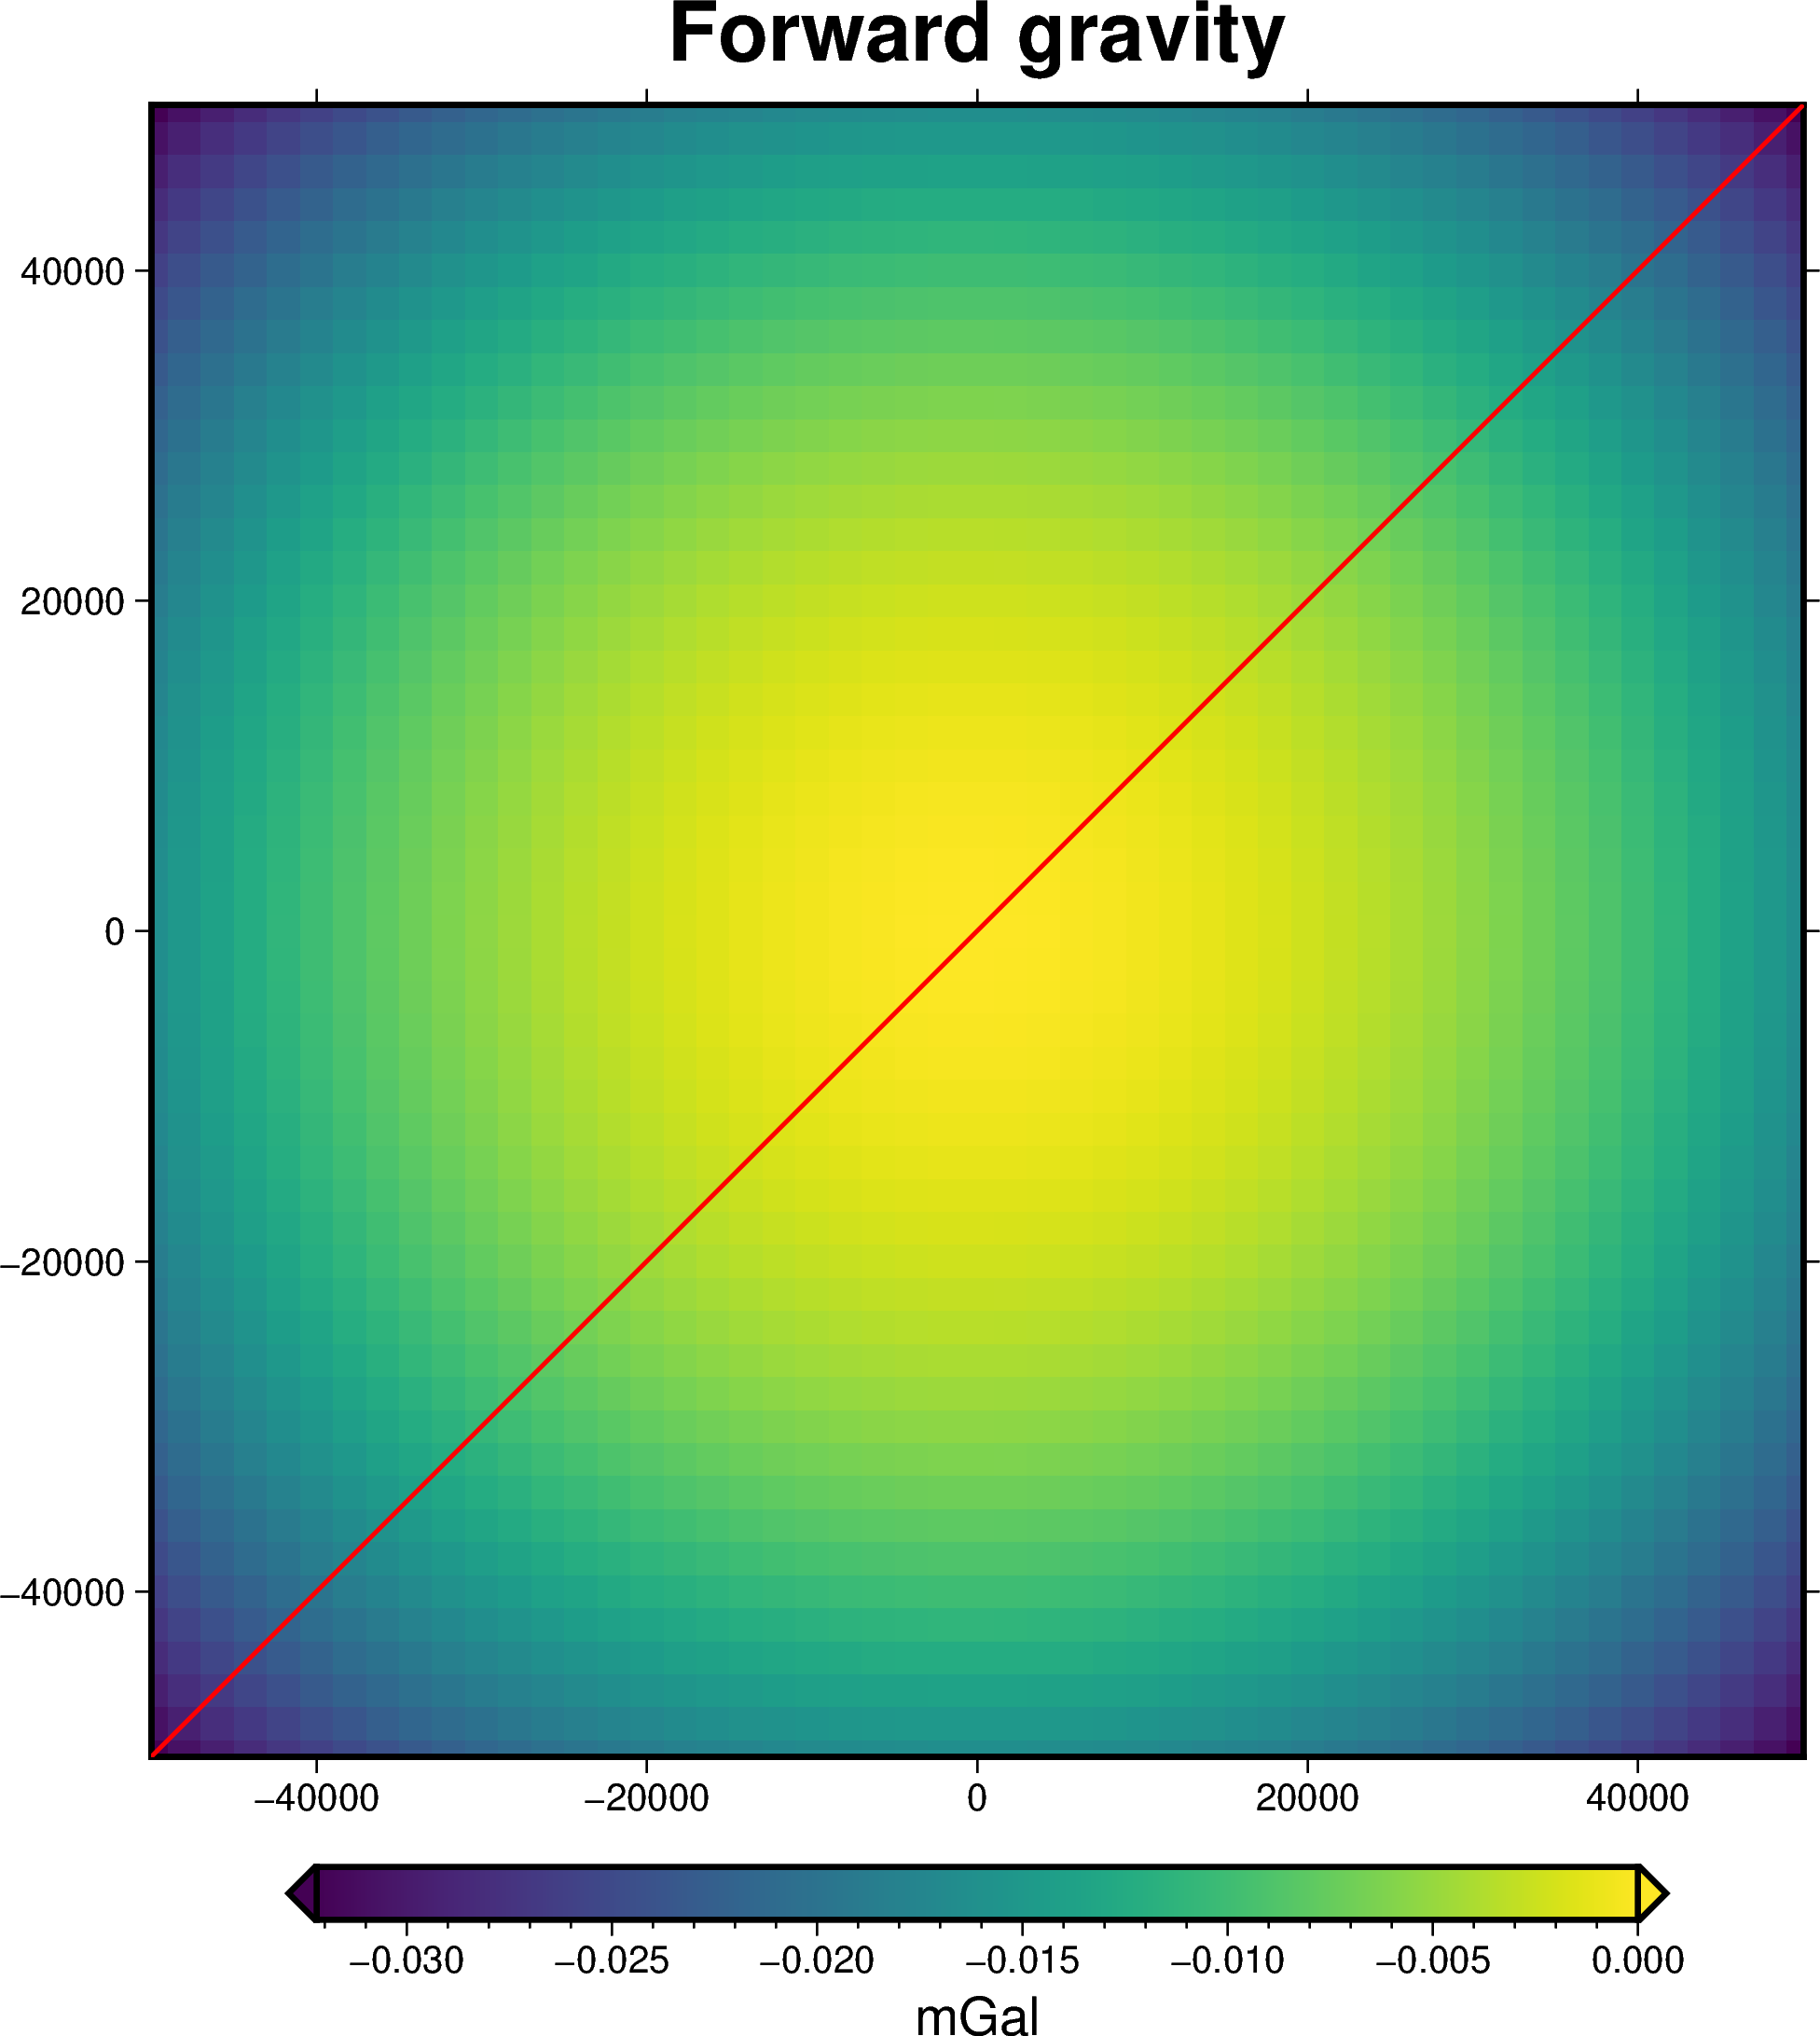

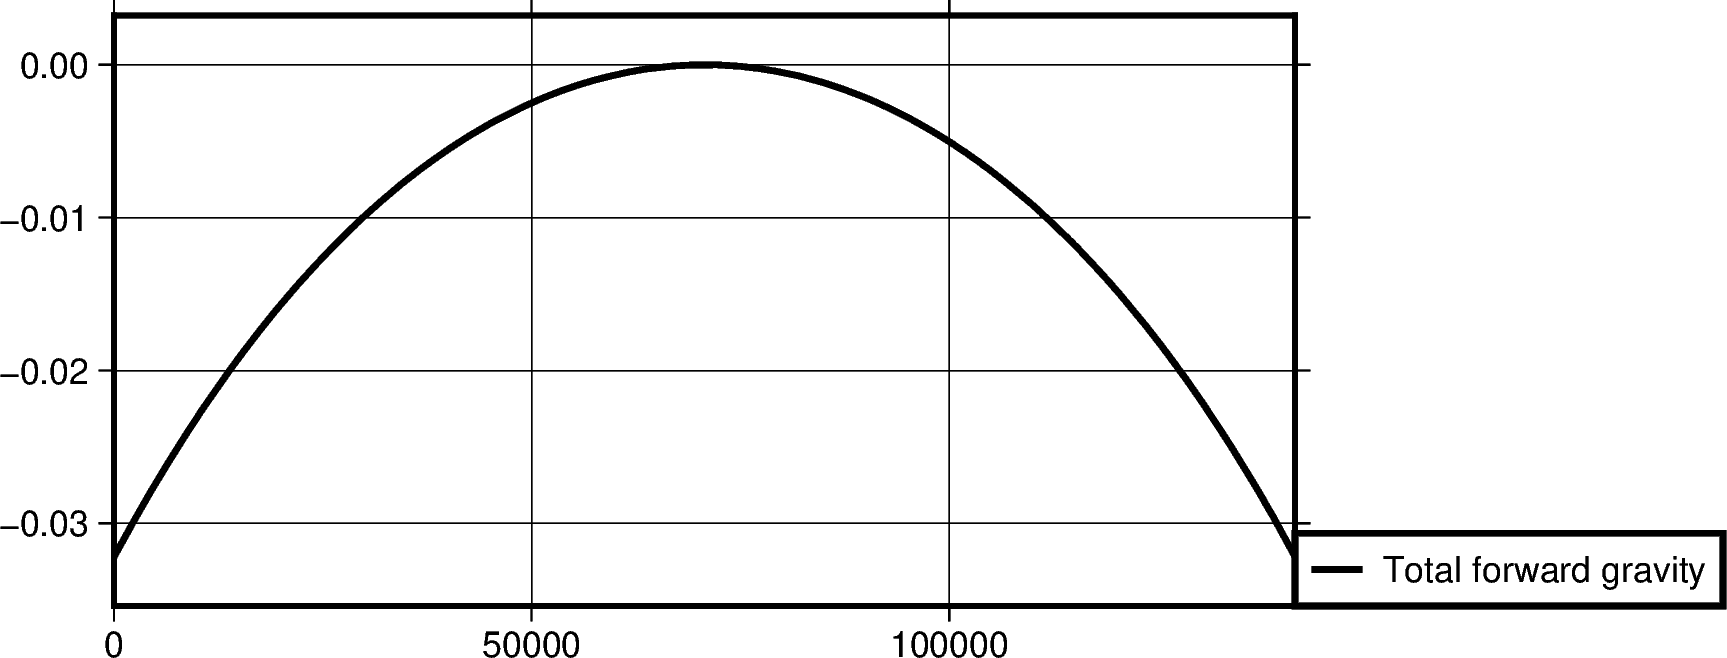

forward calculation took 9.711226463317871 secs


In [6]:
prisms = inv_utils.grids_to_prisms(
    surface,
    prism_base,
    density=density,
)

print(f"Number of prisms: {len(vd.grid_to_table(prisms))}")

plots.show_prism_layers(
    [prisms],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

constant_forward_grav, constant_time = forward_grav_of_prismlayer(
    [prisms],
    observation_points,
    plot=True,
    names=["Forward gravity"],
)
print(f"forward calculation took {constant_time} secs")

## Forward gravity low-res

spacing larger than original, filtering and resampling


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


Number of prisms: 2601


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

  0%|          | 0/2601 [00:00<?, ?it/s]

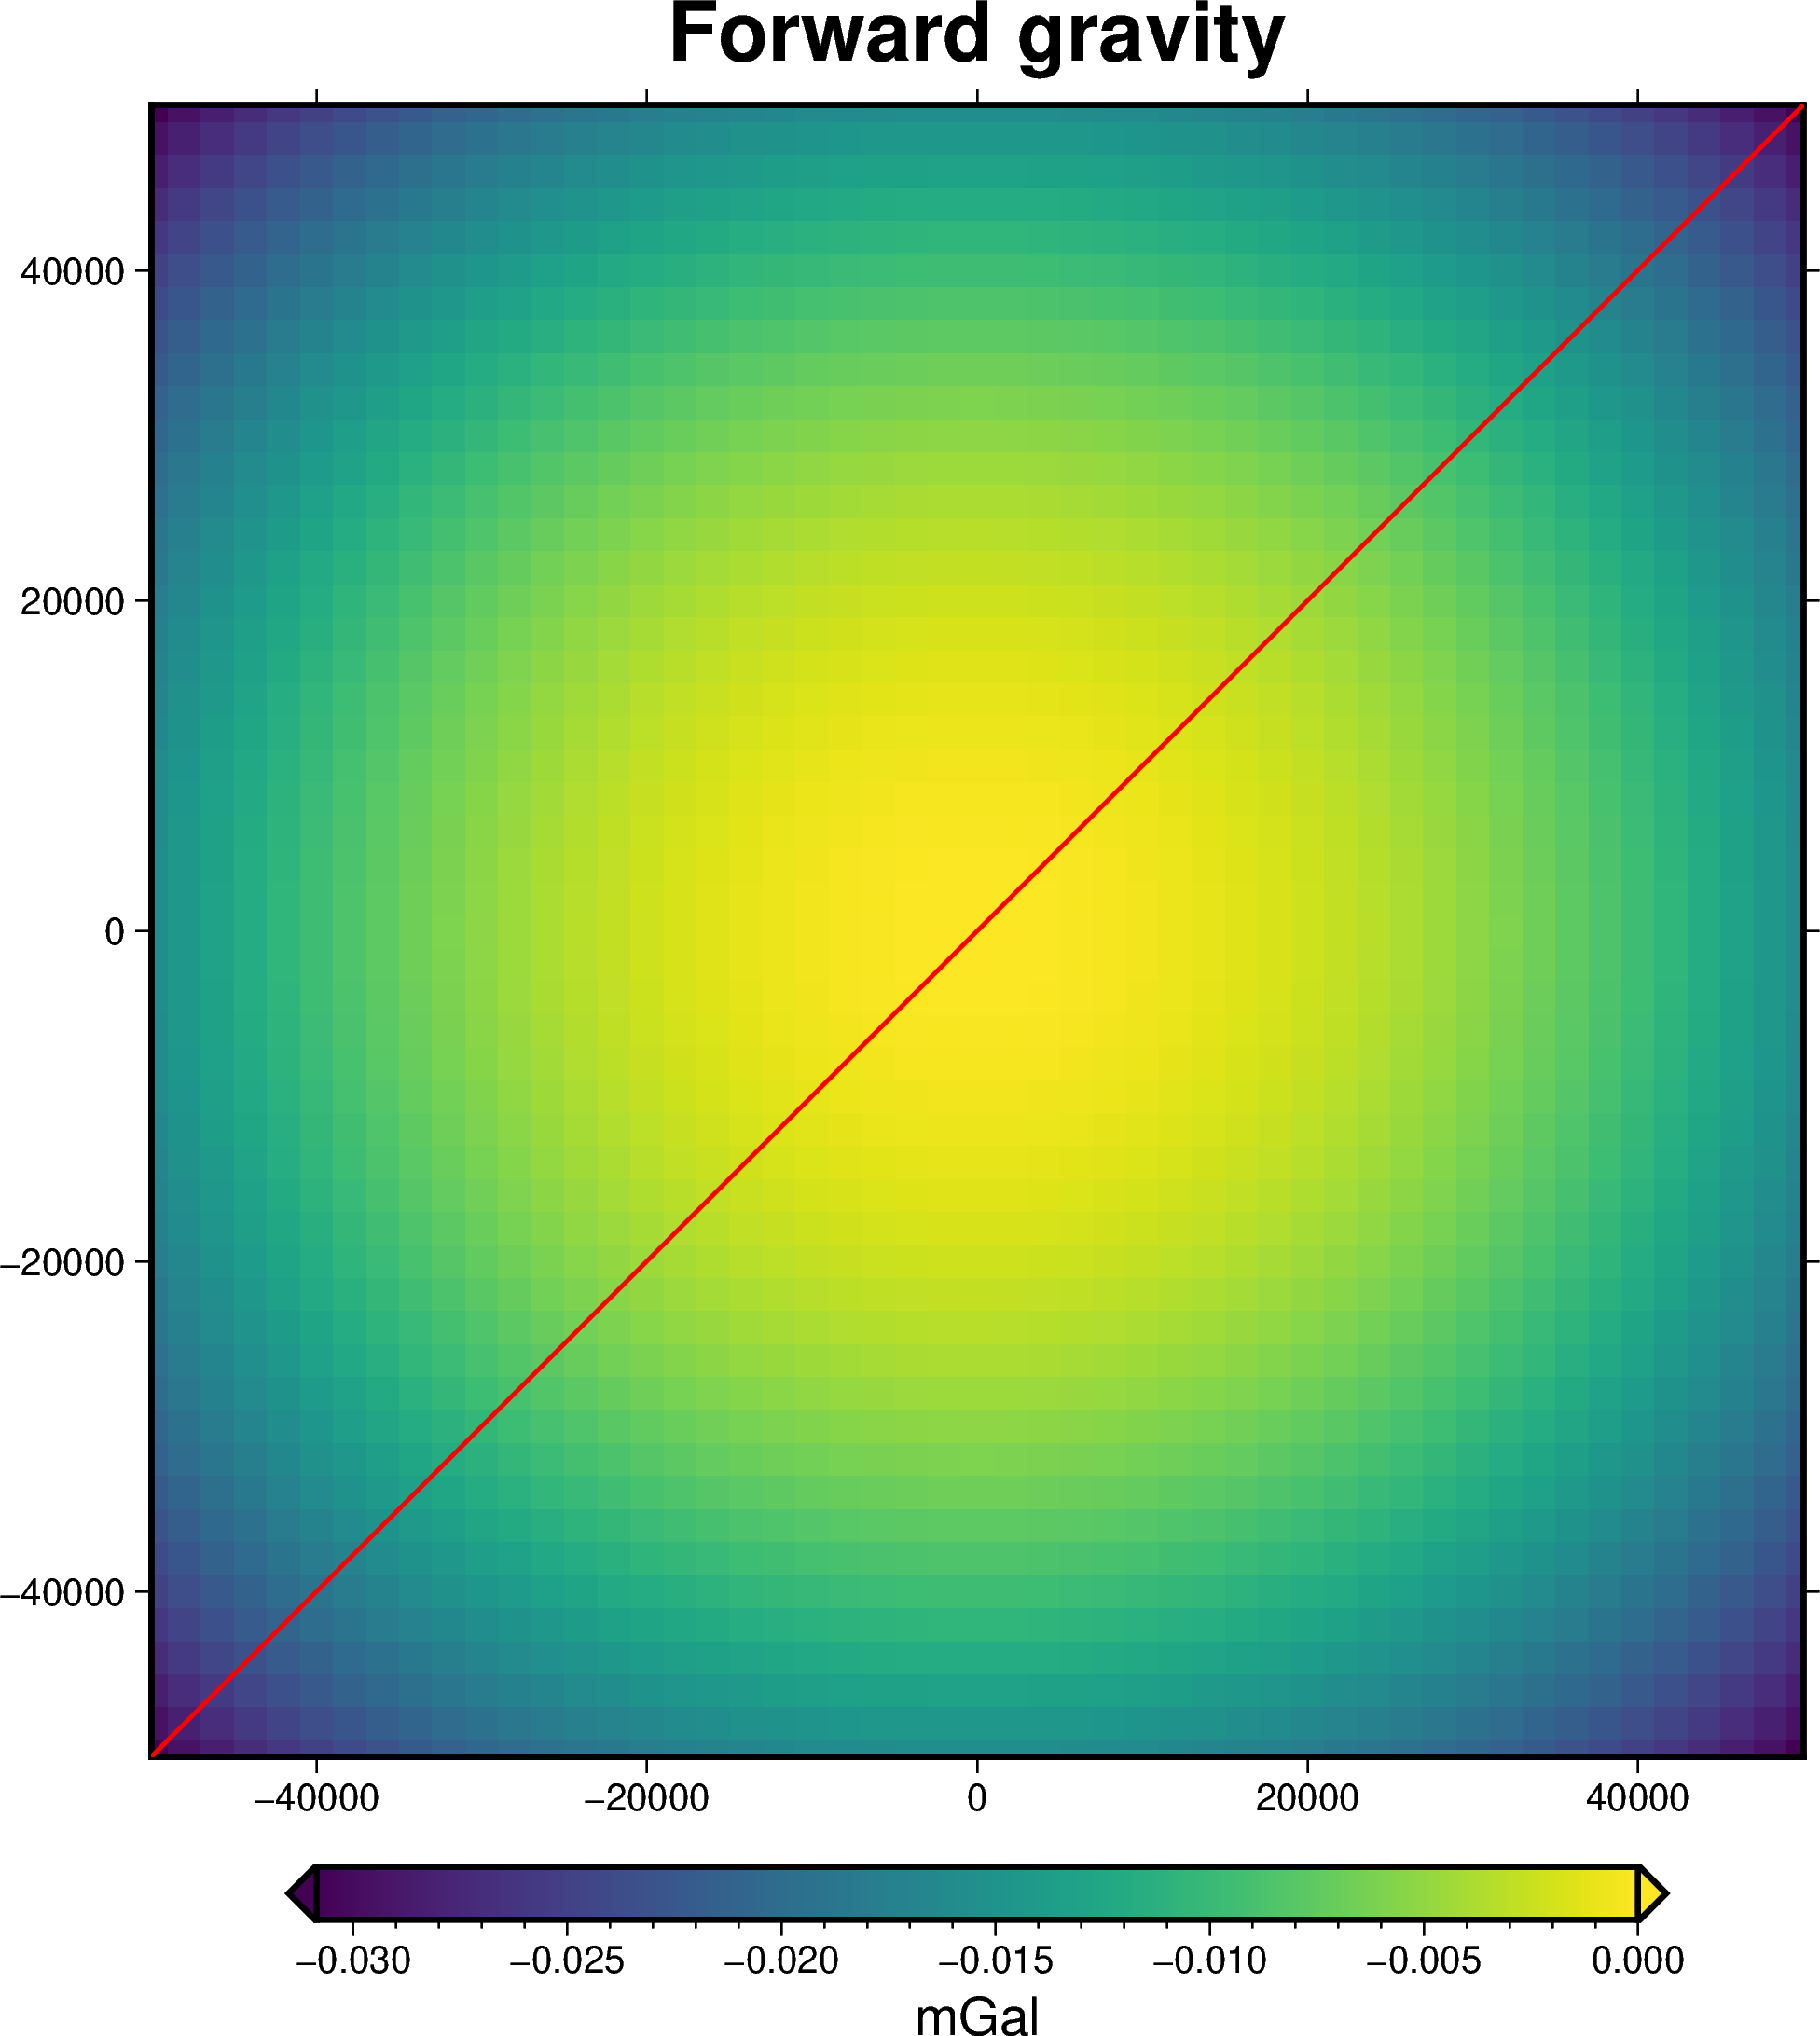

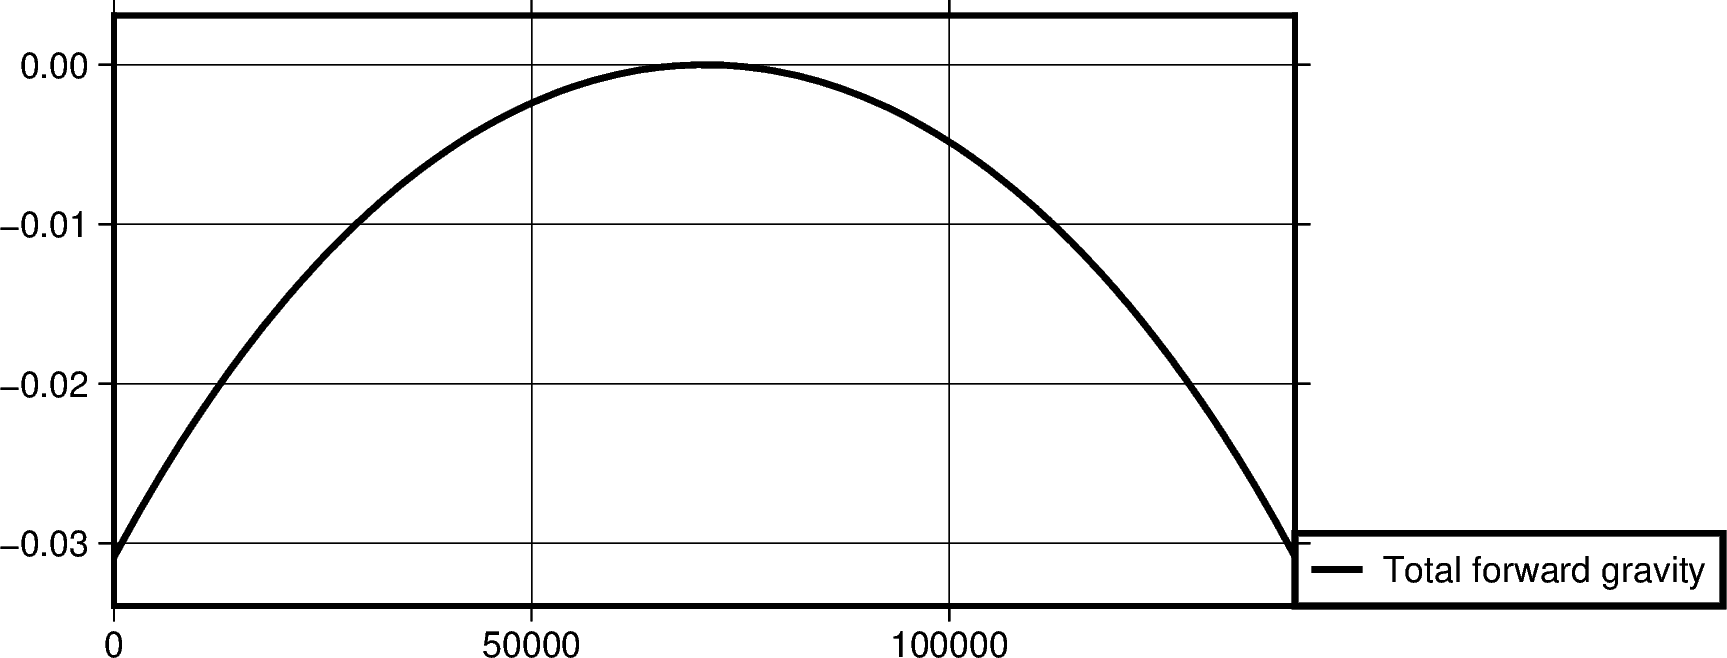

forward calculation took 1.713458776473999 secs


In [7]:
surface_lowres = fetch.resample_grid(
    surface, 
    region=buffer_region, 
    spacing=spacing*3,
    )

prisms_lowres = inv_utils.grids_to_prisms(
    surface_lowres,
    prism_base,
    density=density,
)

print(f"Number of prisms: {len(vd.grid_to_table(prisms_lowres))}")

plots.show_prism_layers(
    [prisms_lowres],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

constant_forward_grav_lowres, constant_time = forward_grav_of_prismlayer(
    [prisms_lowres],
    observation_points,
    plot=True,
    names=["Forward gravity"],
)
print(f"forward calculation took {constant_time} secs")

## Compare resolutions

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


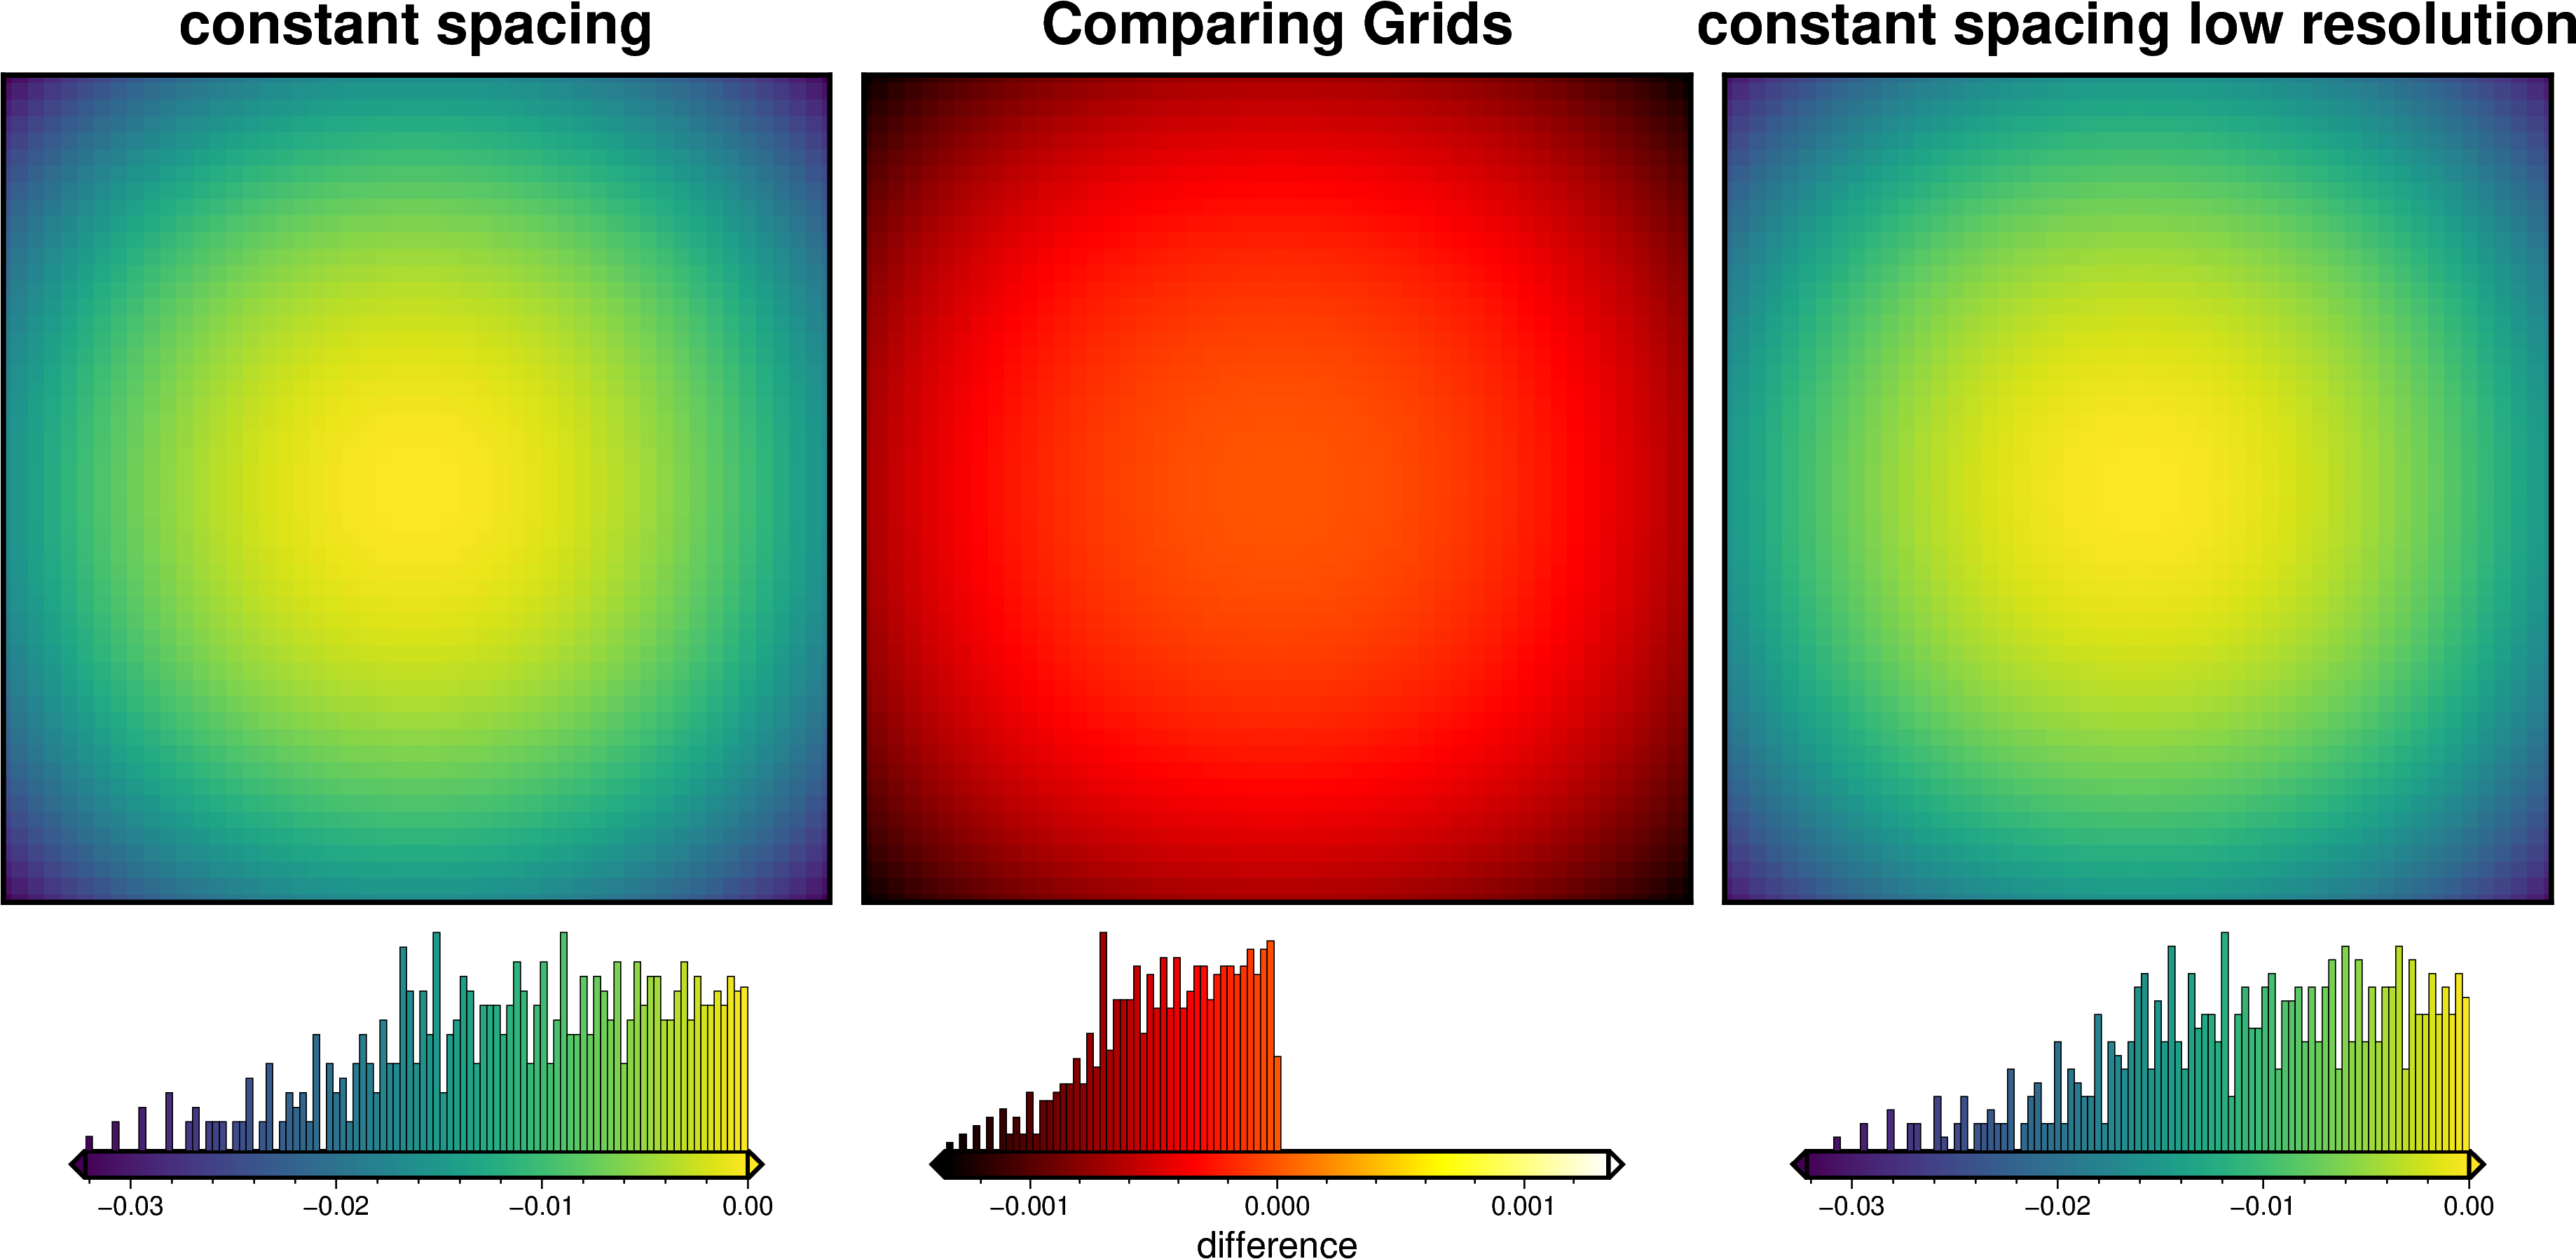

In [8]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    constant_forward_grav_lowres[0],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="constant spacing low resolution",
    show_region=inner_region,
    diff_cmap="hot",
    hist=True,
)

# 1 expanding buffer zone

## make surface grid (inner and buffer)

returning grid with new region and/or registration, same spacing
spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


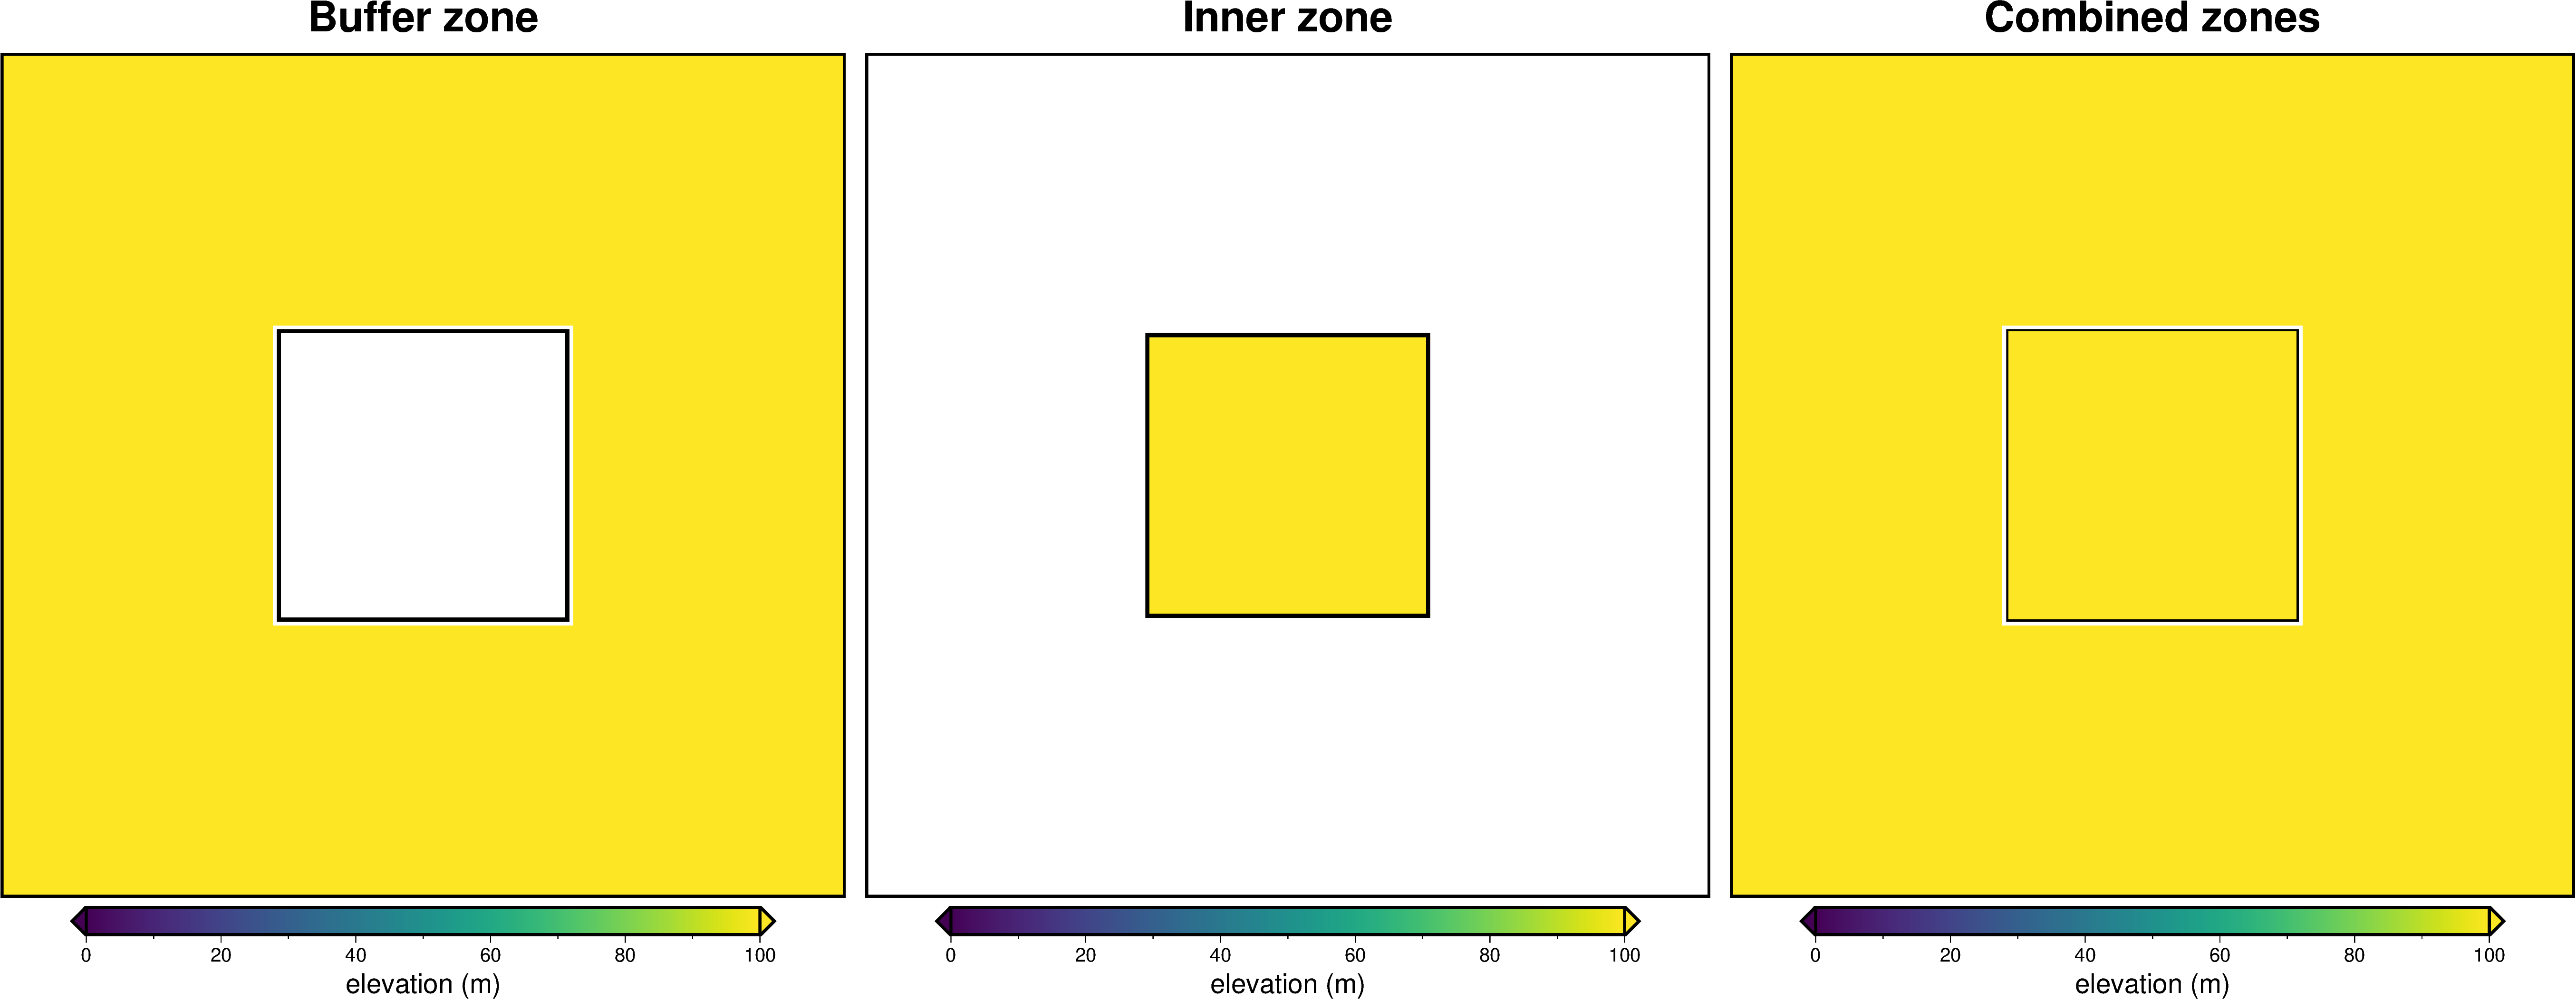

In [9]:
inner_surface = fetch.resample_grid(
    surface, 
    region=utils.alter_region(
        inner_region, 
        )[0], 
    registration='p')

buffer_spacing = int(spacing*2)

buffer_surface = fetch.resample_grid(
    surface, 
    spacing=buffer_spacing,
    registration='p')

buffer_surface = buffer_surface.where(
    (buffer_surface.x < inner_region[0]) |  
    (buffer_surface.x > inner_region[1]) |
    (buffer_surface.y < inner_region[2]) |
    (buffer_surface.y > inner_region[3])
    )

# plot buffer zone
fig = maps.plot_grd(
    buffer_surface,
    cpt_lims=[0,100],
    title="Buffer zone",
    cbar_label="elevation (m)",
    show_region=inner_region,
)

# plot inner zone
fig = maps.plot_grd(
    inner_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Inner zone",
    cbar_label="elevation (m)",
    show_region=inner_region,
    fig=fig,
    origin_shift='xshift',
)

# plot both inner and buffer
fig = maps.plot_grd(
    buffer_surface,
    cpt_lims=[0,100],
    title="Combined zones",
    cbar_label="elevation (m)",
    show_region=inner_region,
    fig=fig,
    origin_shift='xshift',
)
fig.grdimage(inner_surface, cmap=True, transparency=0)

fig.show()

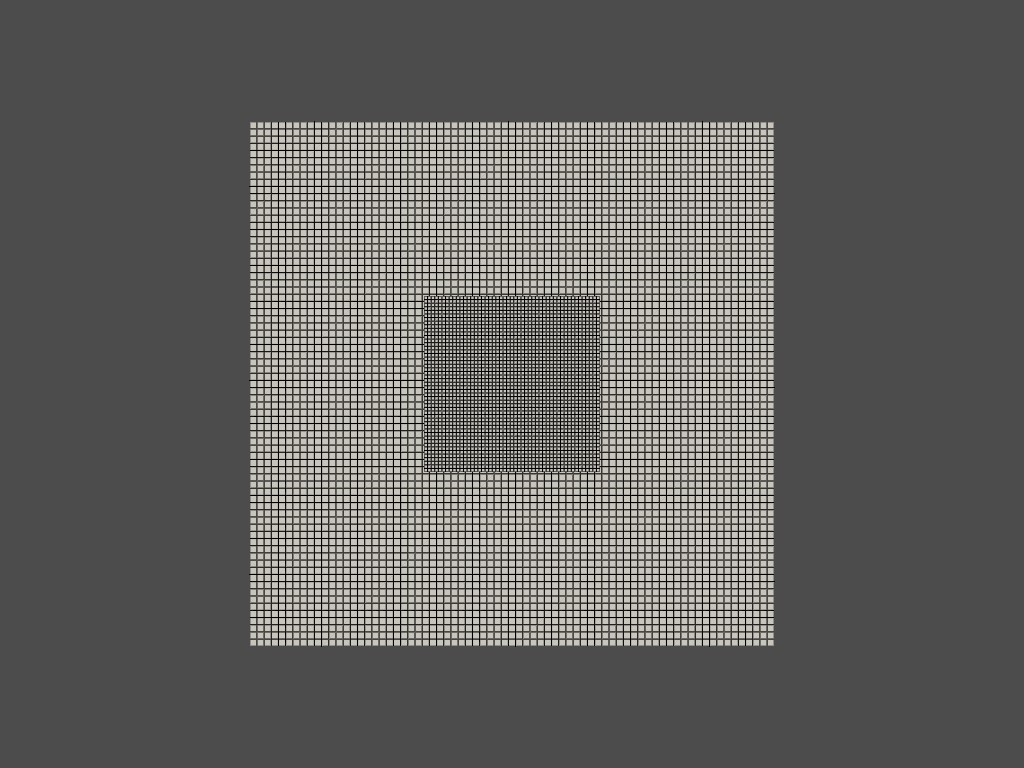

In [10]:
p = pv.Plotter()

p.add_mesh(buffer_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color='white')
p.add_mesh(inner_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color='white')
p.show(cpos='xy', jupyter_backend='static')

## make prism layer

In [11]:
inner_prisms = inv_utils.grids_to_prisms(
    inner_surface,
    prism_base,
    density=density,
)

buffer_prisms = inv_utils.grids_to_prisms(
    buffer_surface,
    prism_base,
    density=density,
)

num = len(vd.grid_to_table(inner_prisms)) + \
    len(vd.grid_to_table(buffer_prisms))

print(f"Number of prisms: {num}")

plots.show_prism_layers(
    [inner_prisms, buffer_prisms],
    color_by='constant',
    clip_box=False,
    zscale=150,
    show_edges=True,
)

Number of prisms: 7976


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## calculate forward gravity

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

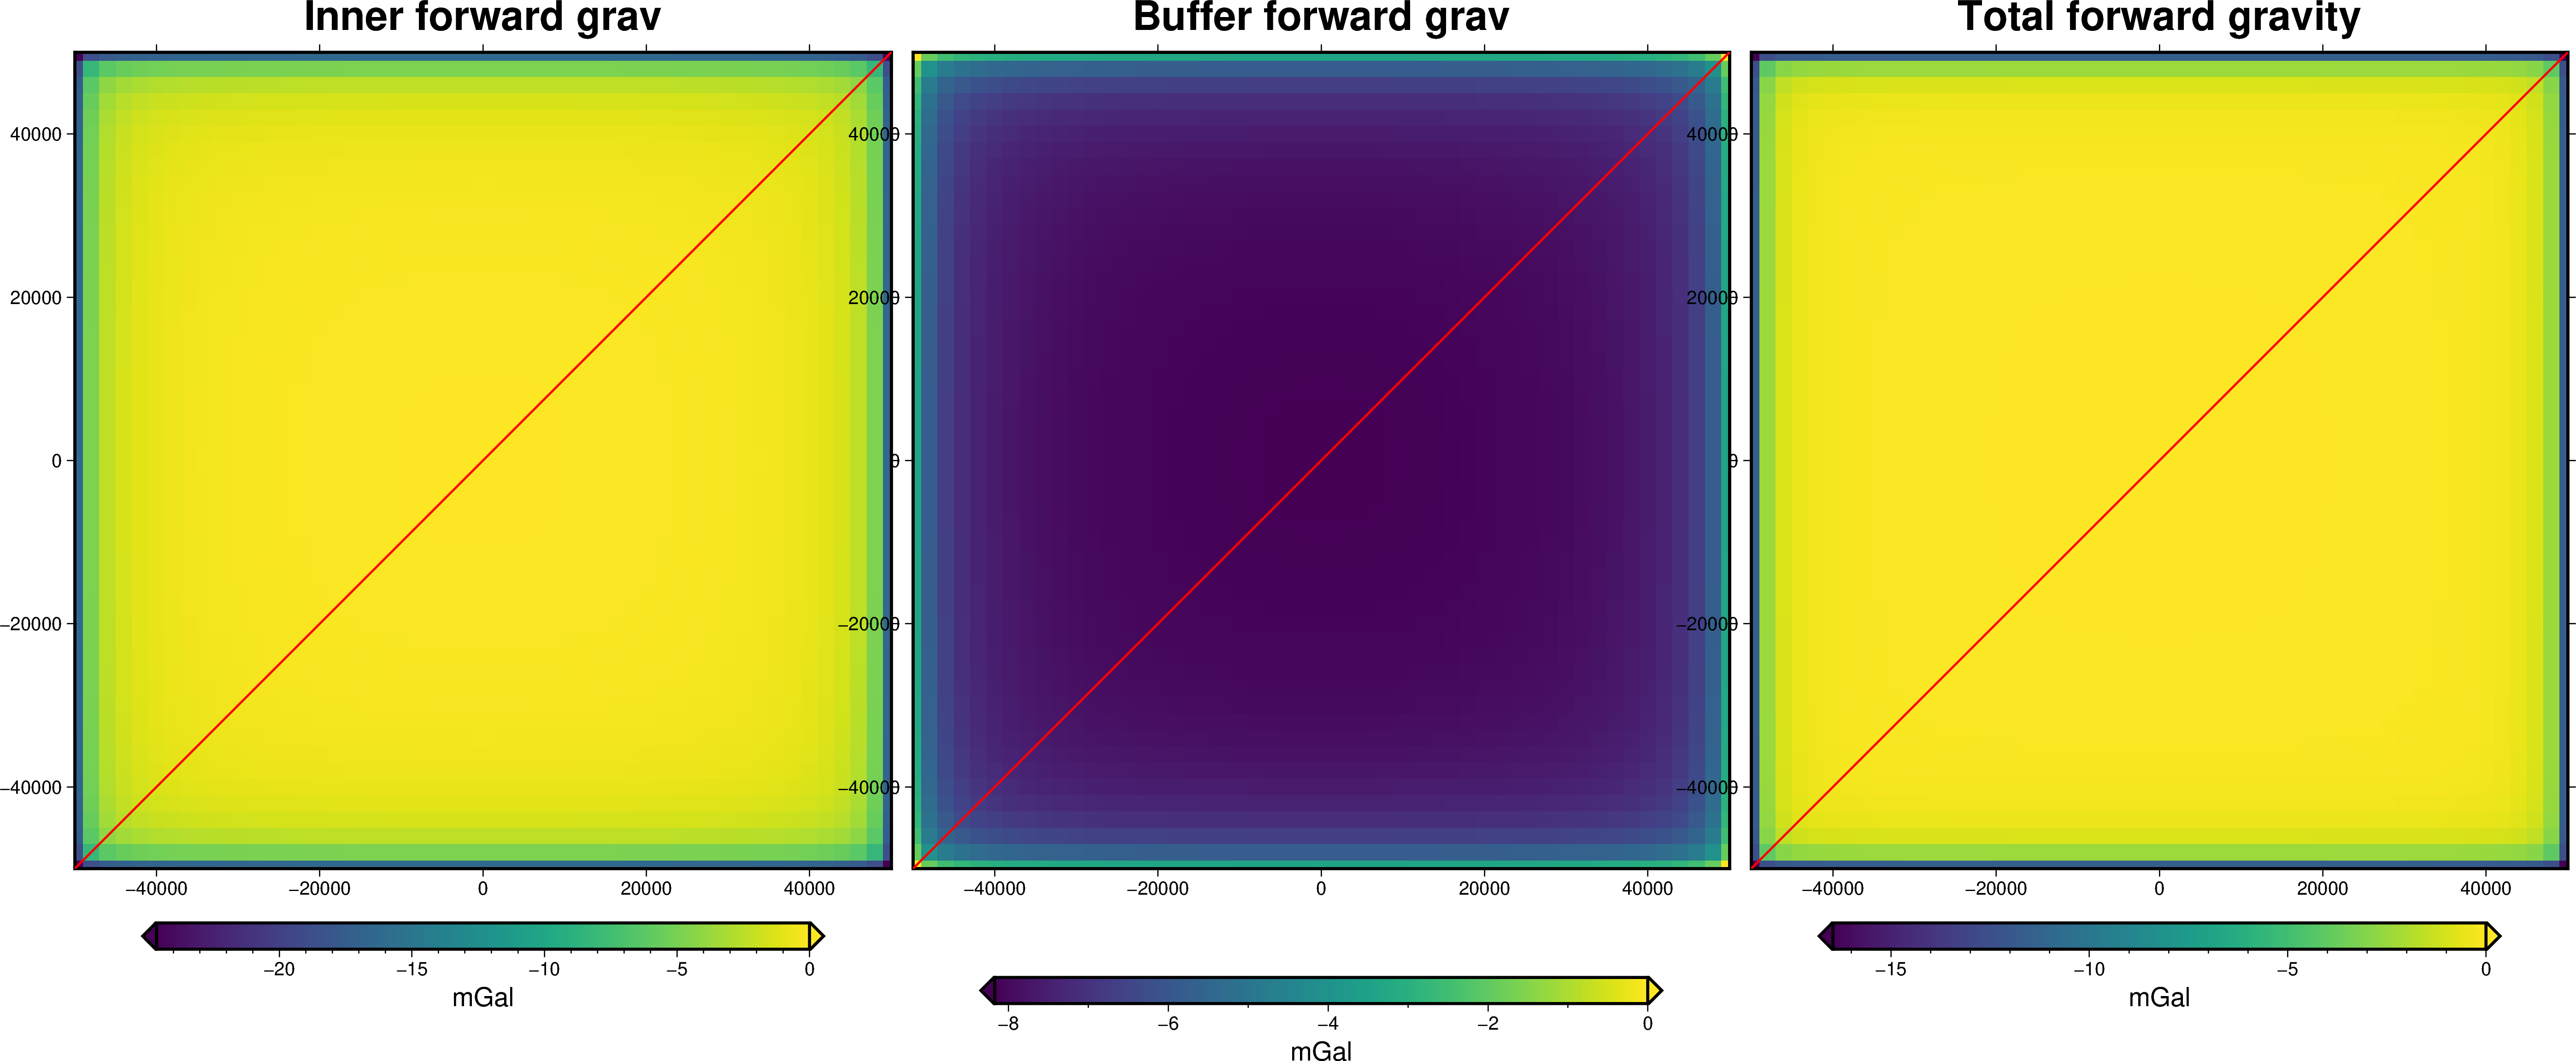

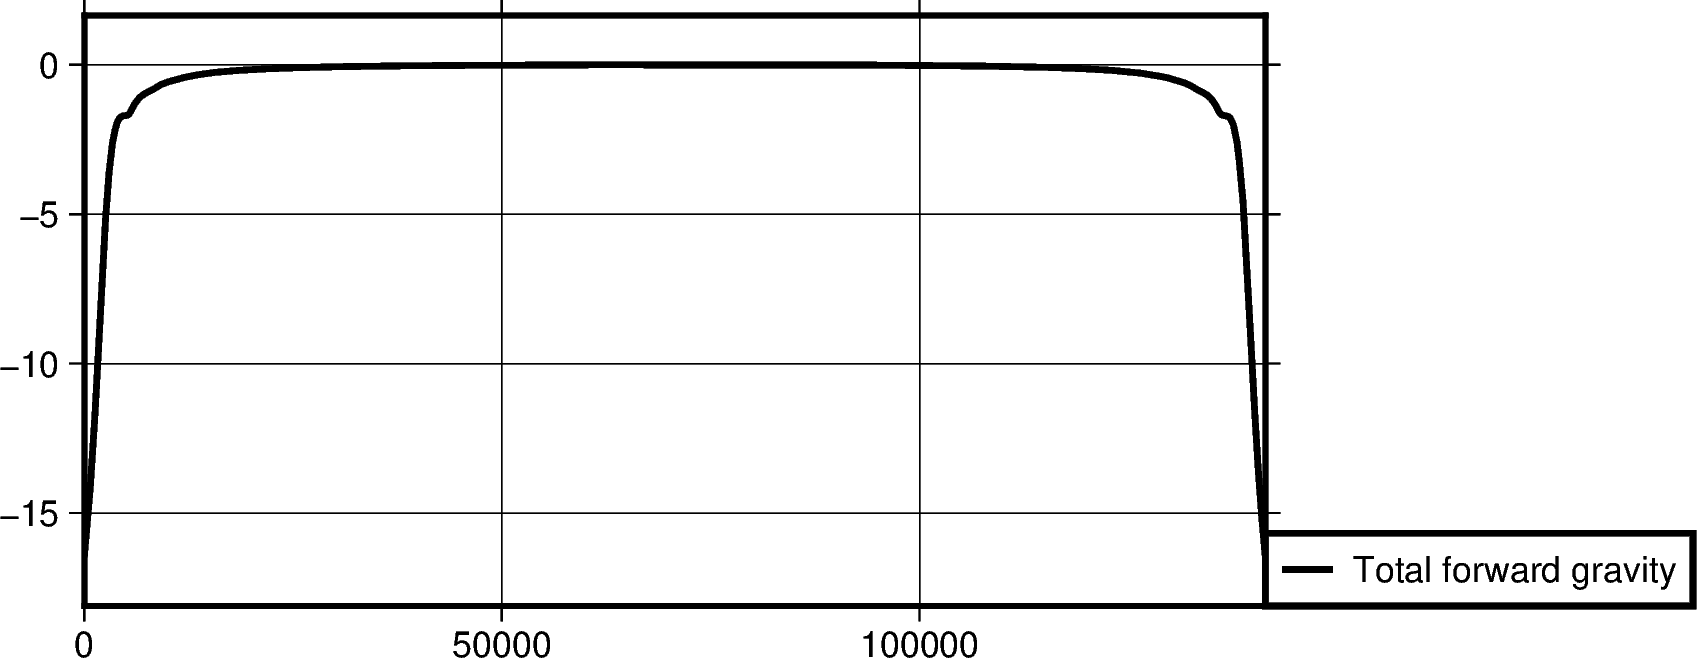

forward calculation took 2.9186649322509766 secs


In [12]:
single_buffer_forward_grav, single_buffer_time = forward_grav_of_prismlayer(
    [inner_prisms, buffer_prisms],
    observation_points,
    plot=True,
    names=["Inner forward grav", "Buffer forward grav"],
)
print(f"forward calculation took {single_buffer_time} secs")

# 2 expanding buffer zones

## define regions

In [13]:
buffer1_region = utils.alter_region(inner_region, buffer=buffer_zoom/2)[1]
buffer2_region = utils.alter_region(buffer1_region, buffer=buffer_zoom/2)[1]

print(inner_region)
print(buffer1_region)
print(buffer2_region)

[-50000.0, 50000.0, -50000.0, 50000.0]
[-100000, 100000, -100000, 100000]
[-150000, 150000, -150000, 150000]


## make surface grids

spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


spacing larger than original, filtering and resampling


grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


returning grid with new region and/or registration, same spacing


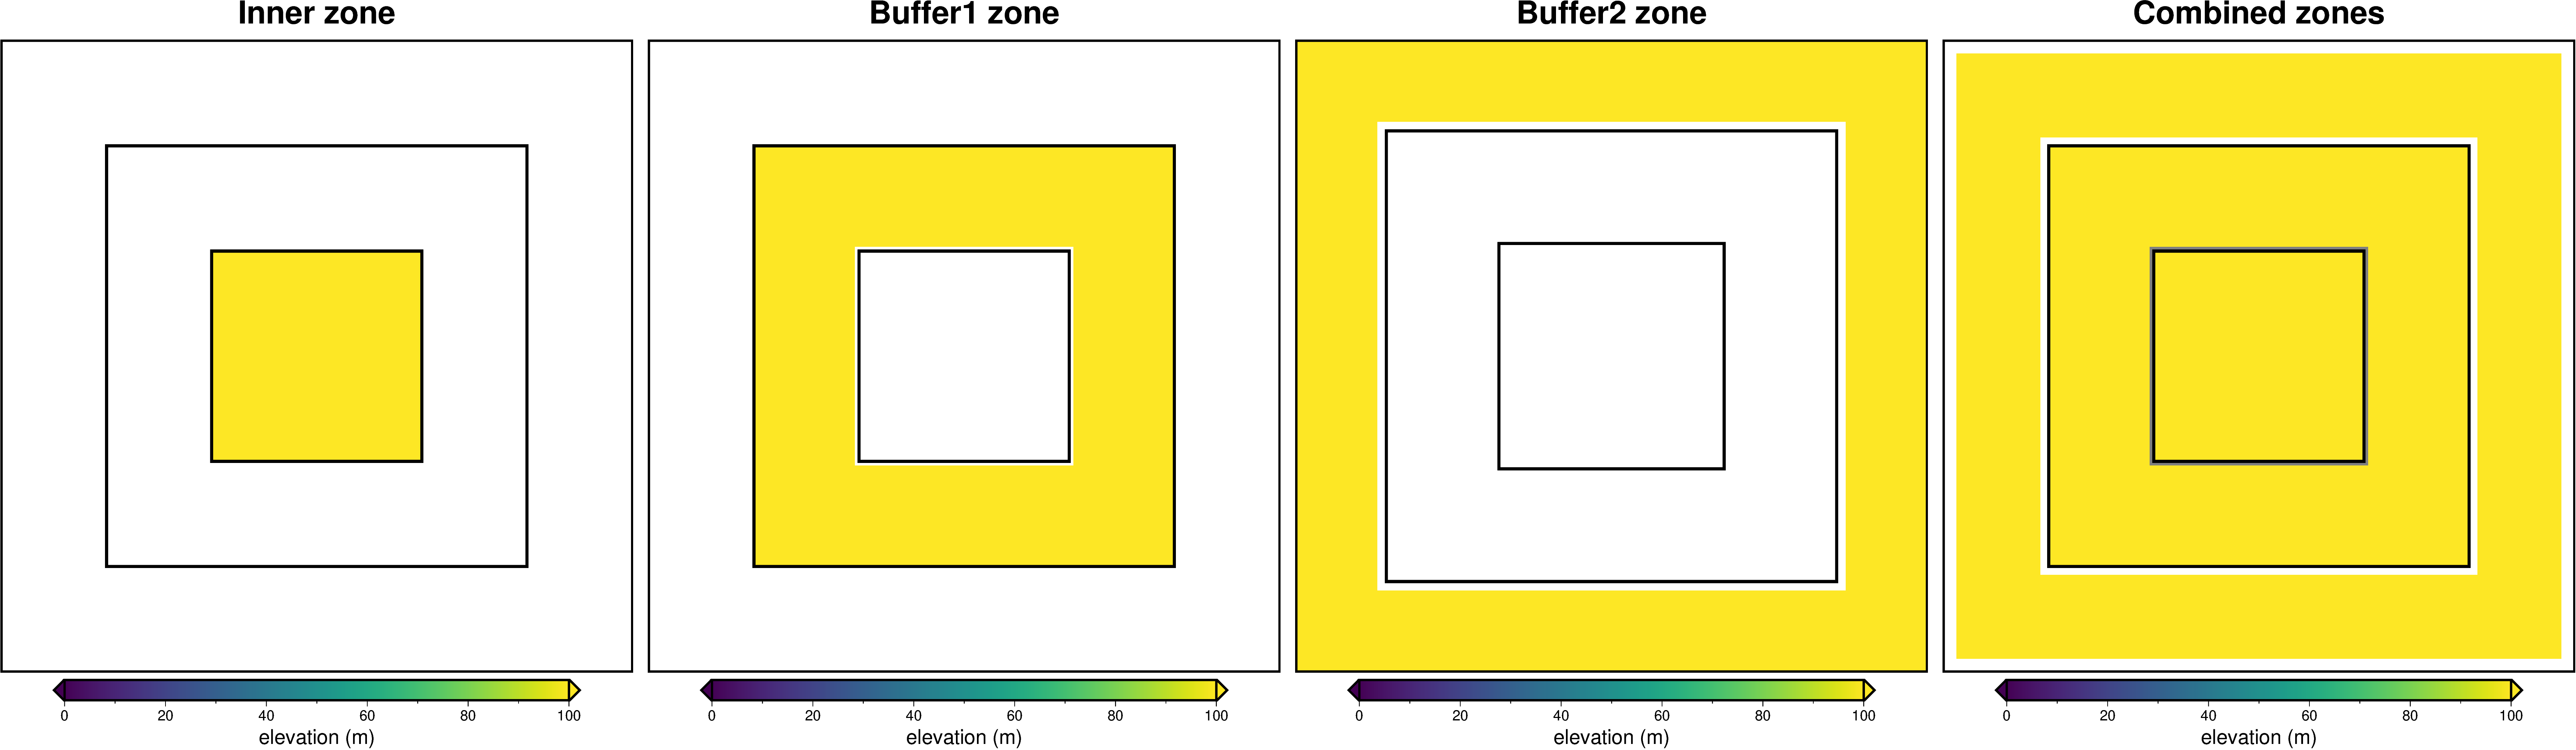

In [14]:
buffer1_spacing = spacing*2
buffer2_spacing = buffer1_spacing*2

buffer1_surface = fetch.resample_grid(
    surface, 
    spacing=buffer1_spacing,
    registration='p')

buffer2_surface = fetch.resample_grid(
    surface, 
    spacing=buffer2_spacing,
    registration='p')

# mask outside buffer1
buffer1_surface = fetch.resample_grid(buffer1_surface, region=buffer1_region)

# mask inner region
buffer1_surface = buffer1_surface.where(
    (buffer1_surface.x < inner_region[0]) |  
    (buffer1_surface.x > inner_region[1]) |
    (buffer1_surface.y < inner_region[2]) |
    (buffer1_surface.y > inner_region[3]) 
)

# mask inside buffer1 region
buffer2_surface = buffer2_surface.where(
    (buffer2_surface.x < buffer1_region[0]) |  
    (buffer2_surface.x > buffer1_region[1]) |
    (buffer2_surface.y < buffer1_region[2]) |
    (buffer2_surface.y > buffer1_region[3])
    )

# plot inner zone zone
fig = maps.plot_grd(
    inner_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Inner zone",
    cbar_label="elevation (m)",
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot buffer1 zone
fig = maps.plot_grd(
    buffer1_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Buffer1 zone",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift='xshift',
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot both inner and buffer
fig = maps.plot_grd(
    buffer2_surface,
    cpt_lims=[0,100],
    title="Buffer2 zone",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift='xshift',
)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

# plot 3 regions
fig = maps.plot_grd(
    buffer2_surface,
    region=buffer_region,
    cpt_lims=[0,100],
    title="Combined zones",
    cbar_label="elevation (m)",
    fig=fig,
    origin_shift='xshift',
)
fig.grdimage(buffer1_surface, cmap=True, transparency=0)
fig.grdimage(inner_surface, cmap=True, transparency=0)
maps.add_box(fig, inner_region)
maps.add_box(fig, buffer1_region)

fig.show()

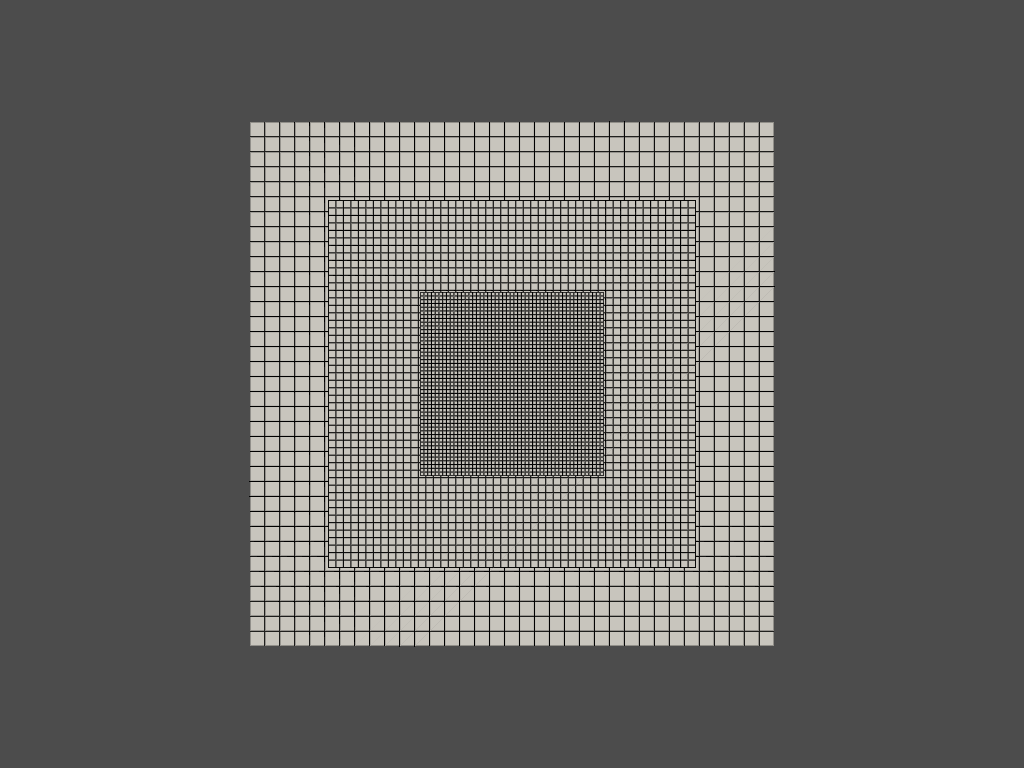

In [15]:
p = pv.Plotter()

p.add_mesh(buffer2_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color='white')
p.add_mesh(buffer1_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color='white')
p.add_mesh(inner_surface.pyvista.mesh(x="x", y="y"), show_edges=True, color='white')

p.show(cpos='xy', jupyter_backend='static')

## make prism layer

In [16]:
inner_prisms = inv_utils.grids_to_prisms(
    inner_surface,
    prism_base,
    density=density,
)

buffer1_prisms = inv_utils.grids_to_prisms(
    buffer1_surface,
    prism_base,
    density=density,
)

buffer2_prisms = inv_utils.grids_to_prisms(
    buffer2_surface,
    prism_base,
    density=density,
)

num = len(vd.grid_to_table(inner_prisms)) + \
    len(vd.grid_to_table(buffer1_prisms)) + \
    len(vd.grid_to_table(buffer2_prisms))

print(f"Number of prisms: {num}")

plots.show_prism_layers(
    [inner_prisms, buffer1_prisms, buffer2_prisms],
    color_by="constant",
    clip_box=False,
    zscale=150,
    show_edges=True,
)

Number of prisms: 6296


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## calculate forward gravity

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

  0%|          | 0/2601 [00:00<?, ?it/s]

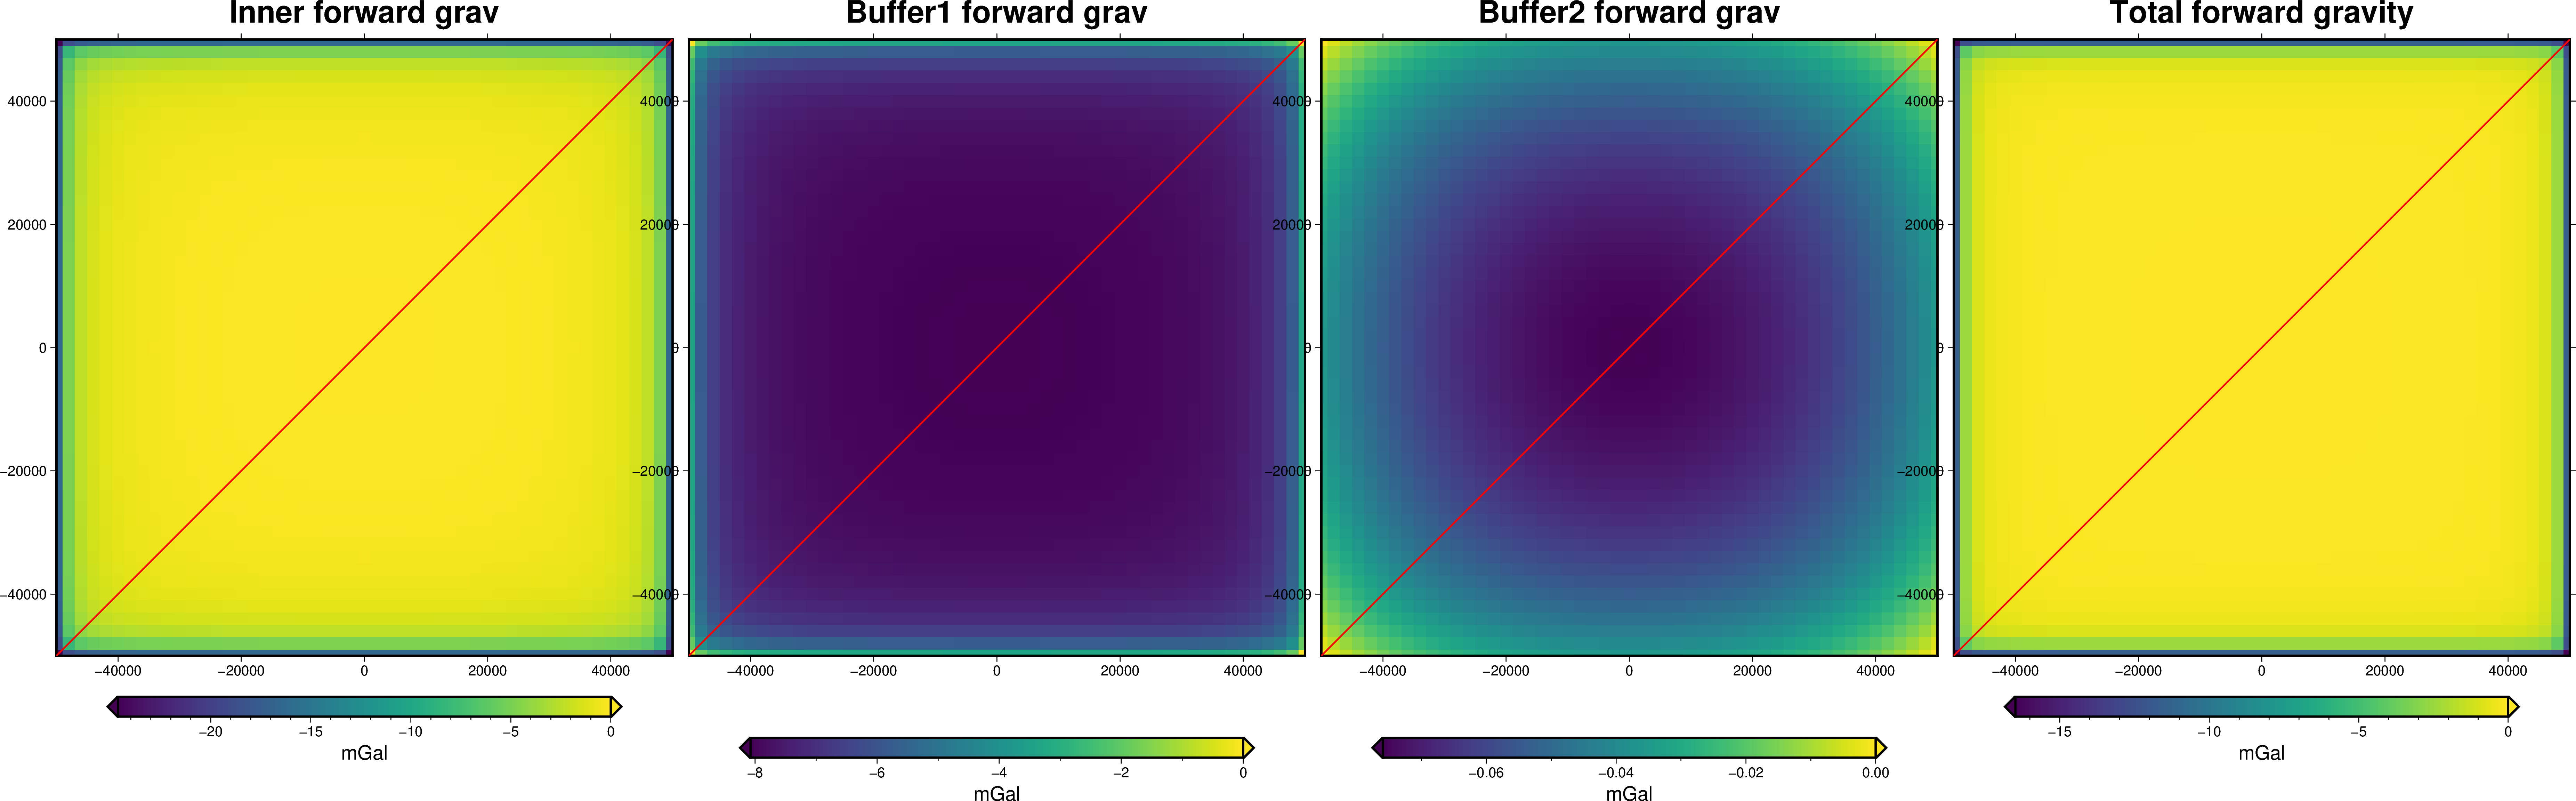

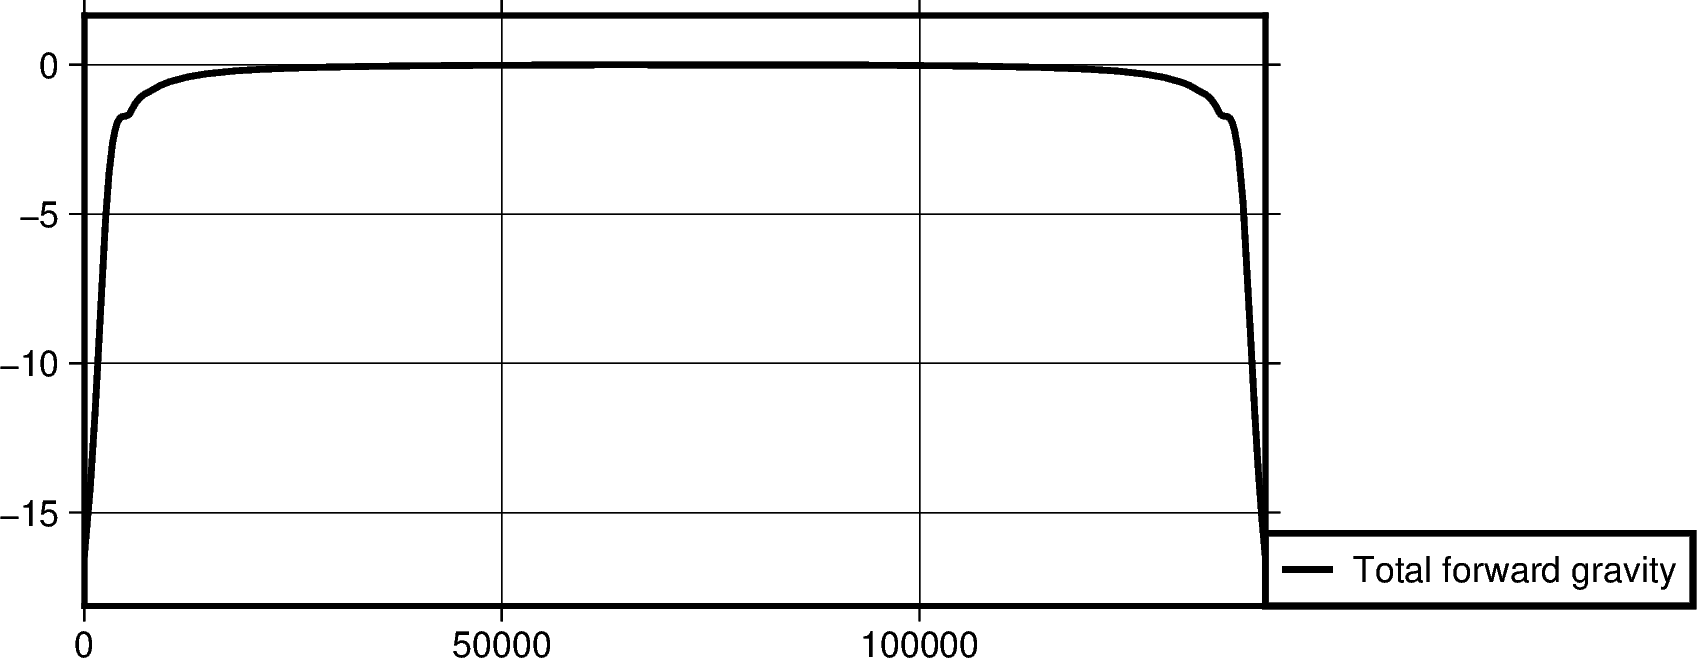

forward calculation took 1.7113687992095947 secs


In [17]:
dual_buffer_forward_grav, dual_buffer_time = forward_grav_of_prismlayer(
    [inner_prisms, buffer1_prisms, buffer2_prisms],
    observation_points,
    plot=True,
    names=["Inner forward grav", "Buffer1 forward grav", "Buffer2 forward grav"],
)
print(f"forward calculation took {dual_buffer_time} secs")

# Compare Methods

<AxesSubplot: xlabel='type', ylabel='number_prisms'>

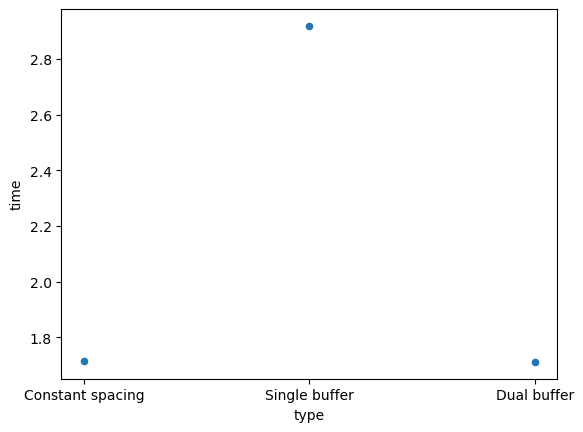

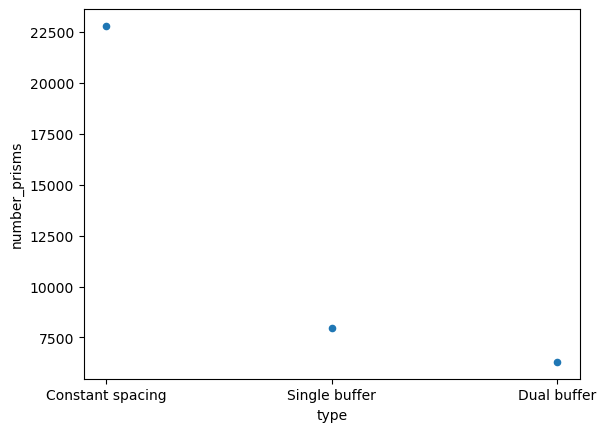

In [18]:
single_buffer_num = len(vd.grid_to_table(inner_prisms)) + \
                    len(vd.grid_to_table(buffer_prisms))
dual_buffer_num = len(vd.grid_to_table(inner_prisms)) + \
                    len(vd.grid_to_table(buffer1_prisms)) + \
                    len(vd.grid_to_table(buffer2_prisms))
df = pd.DataFrame((
    ["Constant spacing", constant_time, len(vd.grid_to_table(prisms))], 
    ["Single buffer", single_buffer_time, single_buffer_num], 
    ["Dual buffer", dual_buffer_time, dual_buffer_num],
    ),
    columns=('type', 'time', 'number_prisms'))
df.plot.scatter('type', "time")
df.plot.scatter('type', "number_prisms")

In [19]:
df.time

0    1.713459
1    2.918665
2    1.711369
Name: time, dtype: float64

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


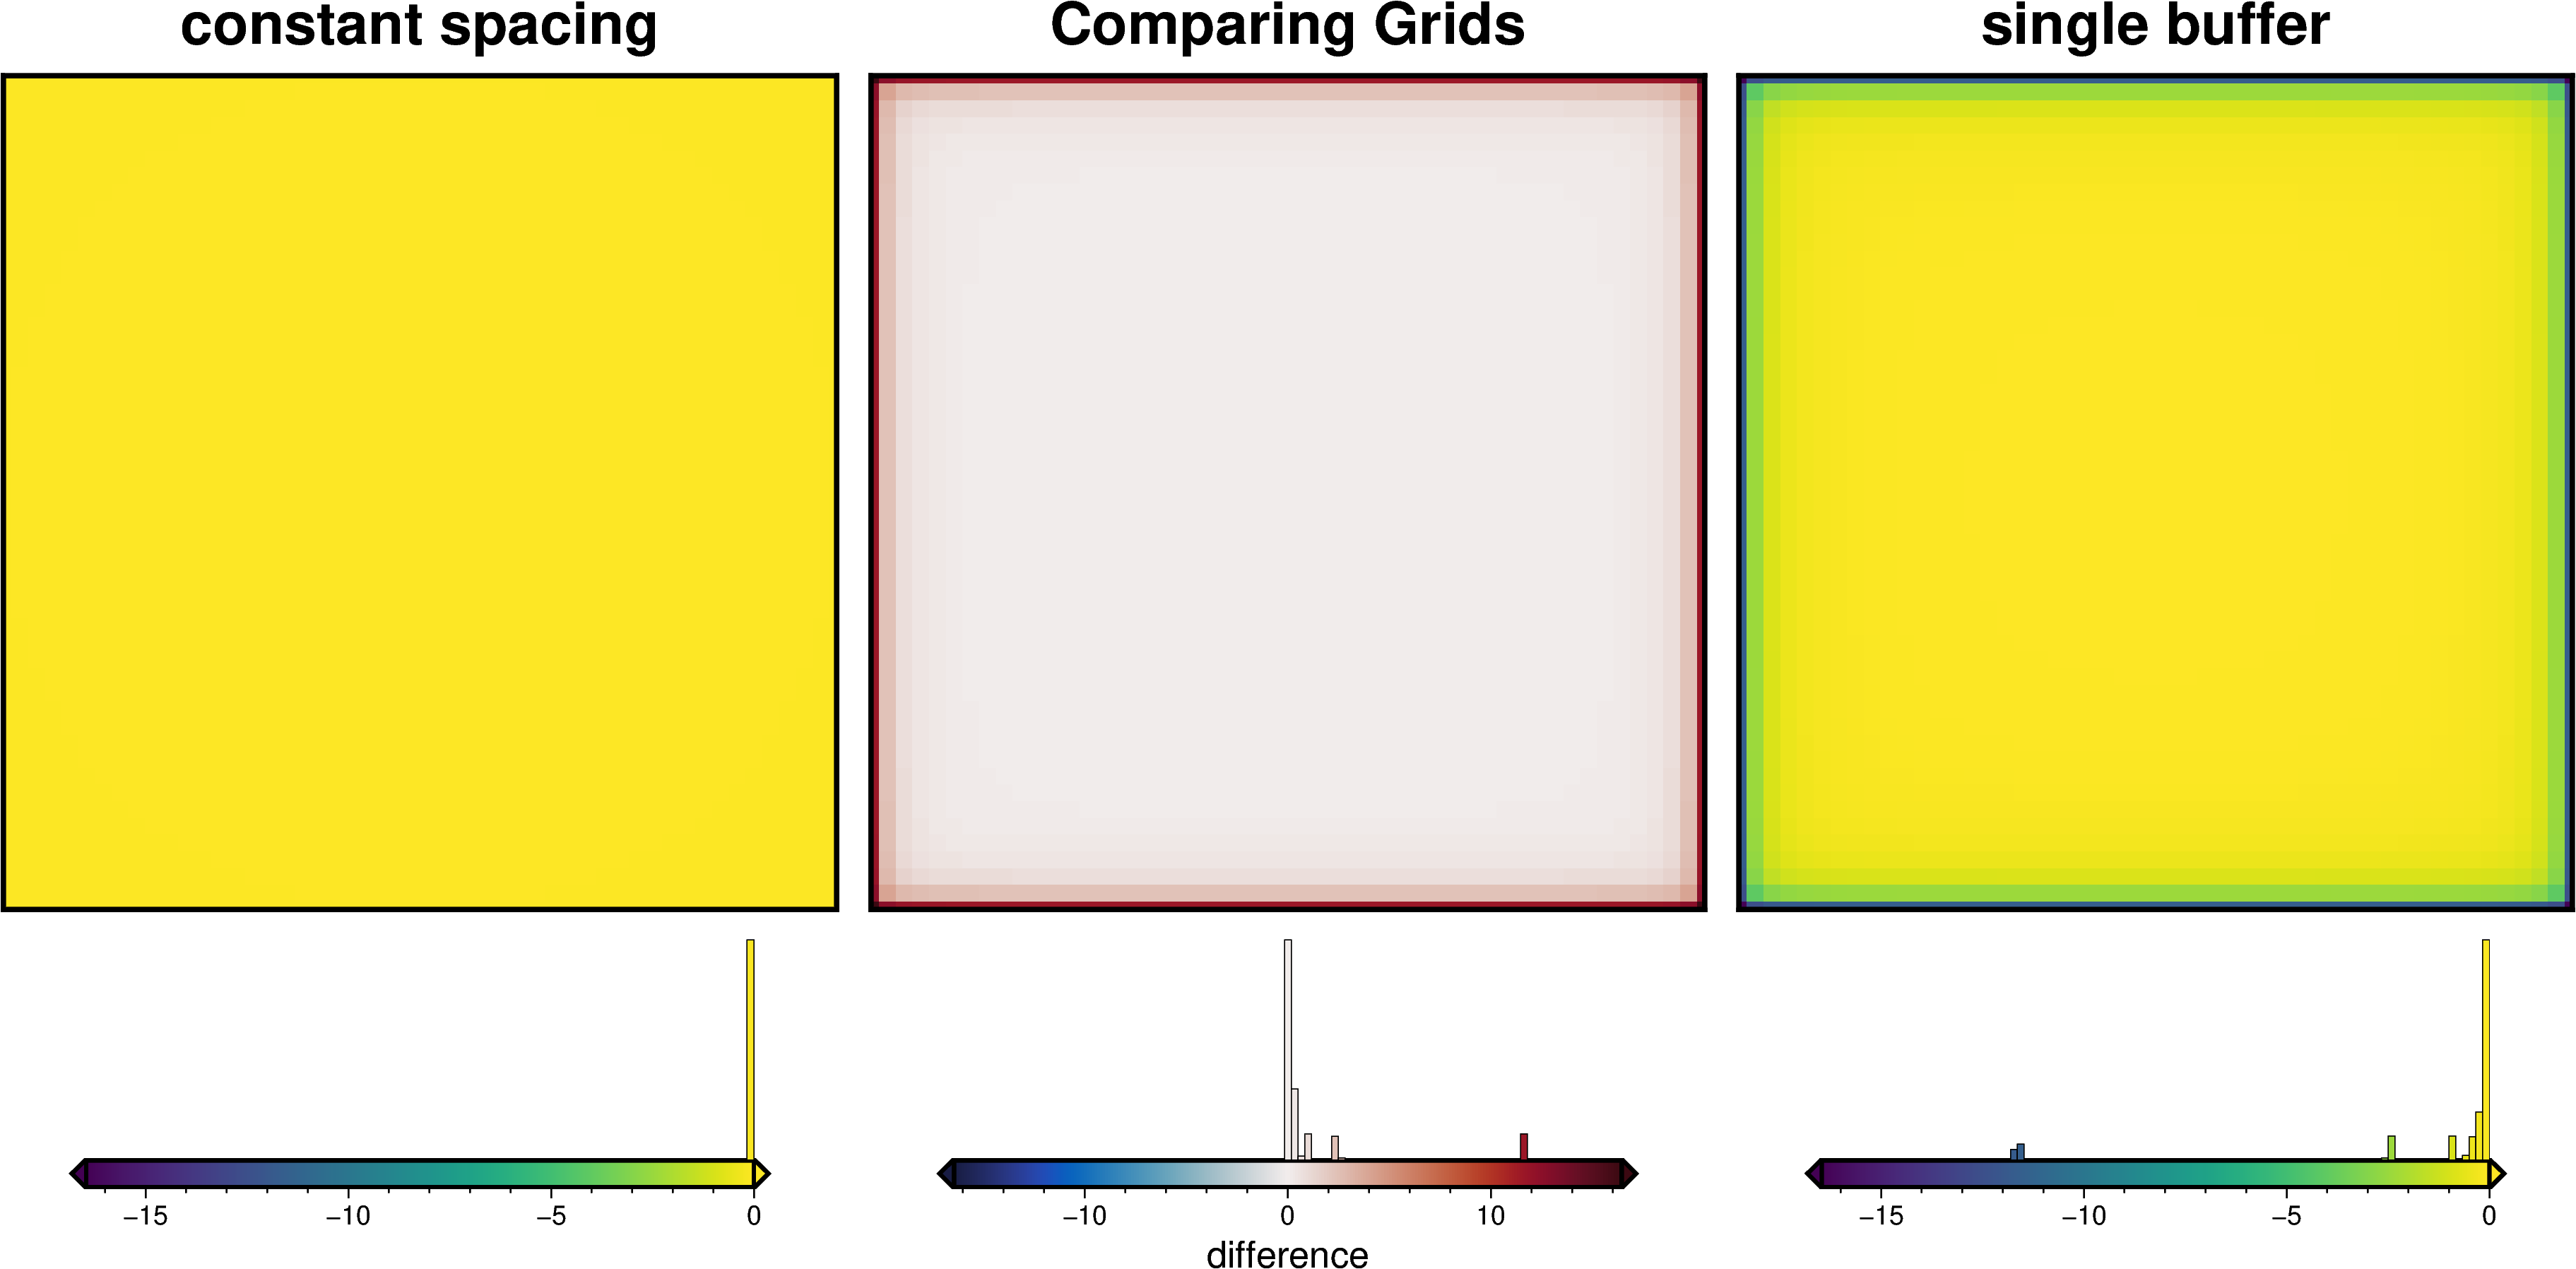

In [20]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    single_buffer_forward_grav[2],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="single buffer",
    show_region=inner_region,
    hist=True,
)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


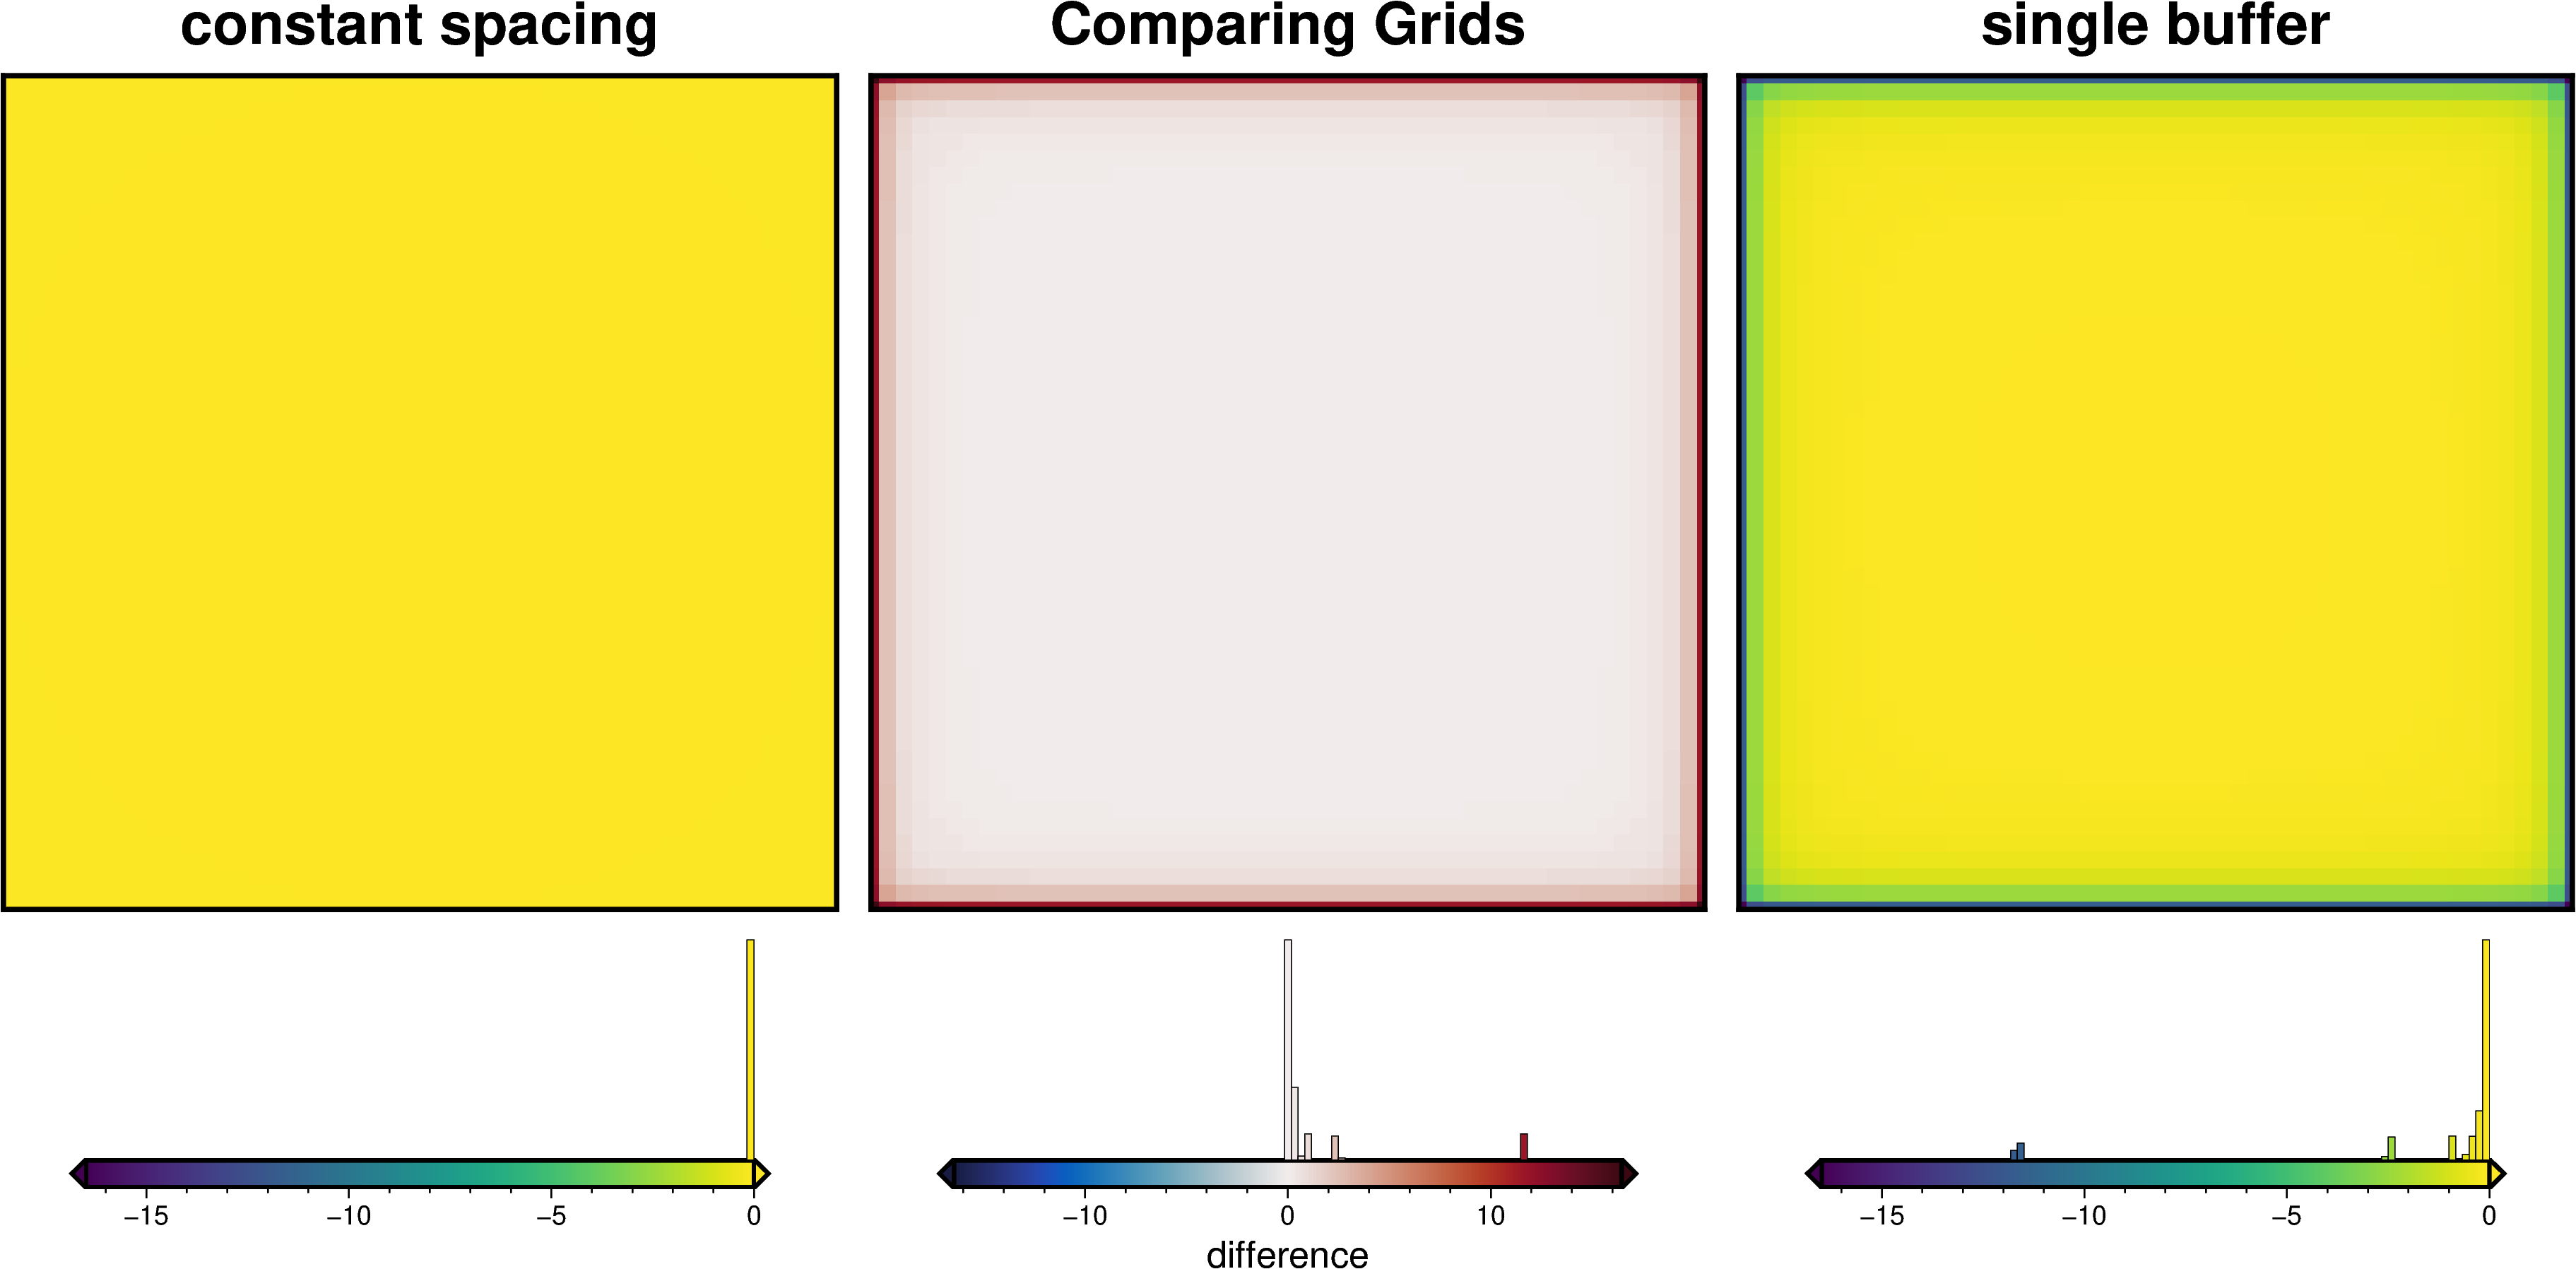

In [21]:
grids = utils.grd_compare(
    constant_forward_grav[0],
    dual_buffer_forward_grav[3],
    plot=True,
    inset=False,
    grid1_name="constant spacing",
    grid2_name="single buffer",
    show_region=inner_region,
    hist=True,
)

In [22]:
frame=["nSwe", "xaf100000", "yaf100000"],

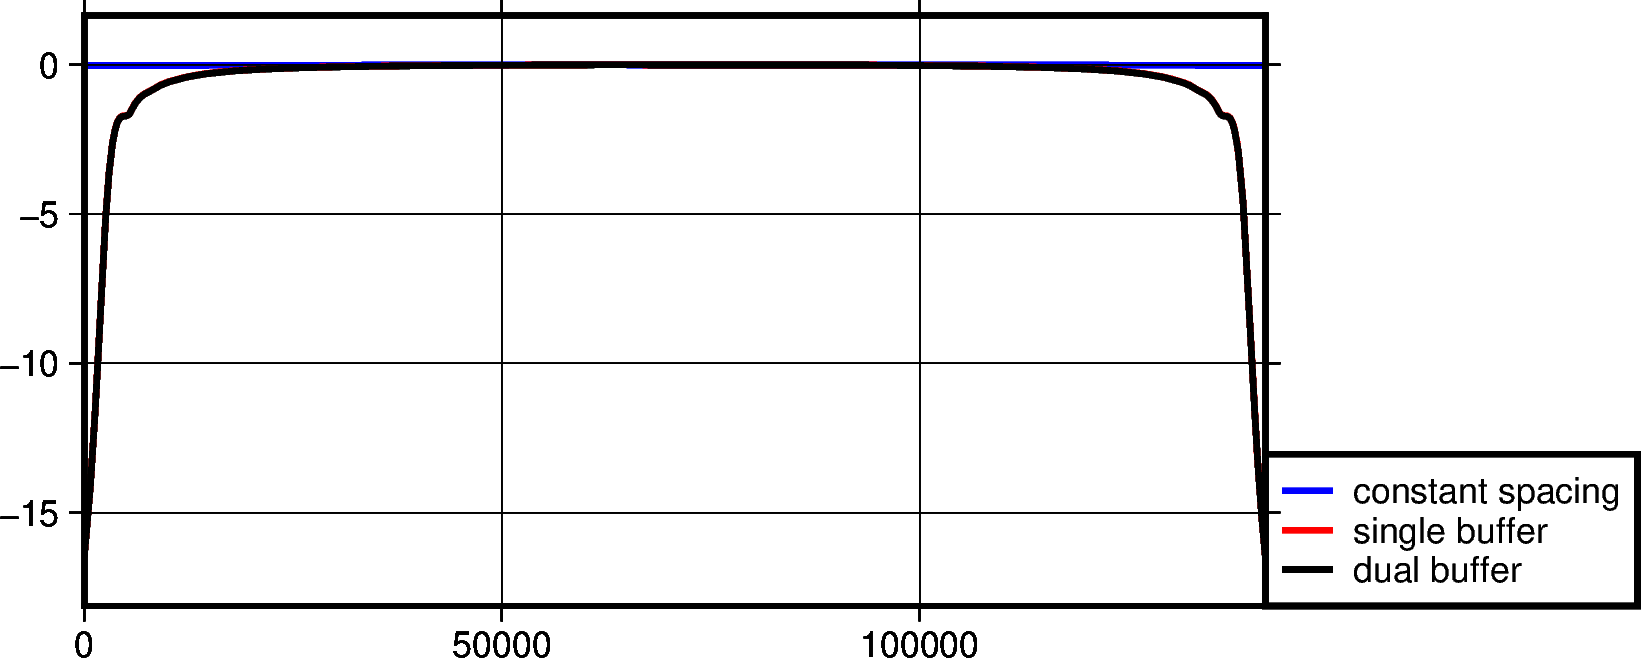

In [23]:
data_dict = profile.make_data_dict(
    names=[
        "constant spacing", 
        "single buffer", 
        "dual buffer"
        ],
    grids=[
        constant_forward_grav[-1], 
        single_buffer_forward_grav[-1], 
        dual_buffer_forward_grav[-1]
        ],
    colors=[
        "blue", 
        "red", 
        "black"
        ],
)

profile.plot_data(
    "points",
    start=(inner_region[0], inner_region[2]),
    stop=(inner_region[1], inner_region[3]),
    data_dict=data_dict,
    share_yaxis=True,
)